# Regularization - How to get a decent architecture?

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.23.4


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.10.0


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [6]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


## Loading and preparing our data set for classification

In [7]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 26800  100 26800    0     0  85897      0 --:--:-- --:--:-- --:--:-- 85897


In [8]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
y=df['group']
df.drop('group', axis='columns', inplace=True)
X = df.as_matrix()

In [9]:
df.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [10]:
df.describe()

,speed,age,miles
count,1500.000000,1500.000000,1500.000000
mean,122.492667,44.952667,30.344000
std,17.604333,17.191727,15.463152
min,68.000000,9.000000,-21.000000
25%,108.000000,32.000000,18.000000
50%,120.000000,42.000000,29.000000
75%,137.000000,55.000000,42.000000
max,166.000000,102.000000,84.000000


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [14]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data, xlim=None, ylim=None):
    h = 1  # step size in the mesh
    if xlim == None:
        xlim = x_data.min(), x_data.max()
    if ylim == None:
        ylim = y_data.min(), y_data.max()
        
    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.arange(x_min - 1, x_max + 1, h),
                         np.arange(y_min - 1, y_max + 1, h))
    return xx, yy, xlim, ylim
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False, xlim=(16, 90), ylim=(70, 170)):
    xx,yy, xlim, ylim = meshGrid(x_data, y_data, xlim, ylim)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)
                
def plot_history(history, samples=100, init_phase_samples=None, plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=(20,10))

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_

In [15]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

num_categories = 3

### We have several means of regularization for neural networks and we use a combination of them as described below.
- reduce capacity of model
- dropout
- batch normalization
- change activation to relu for faster training
- reduce amount of training cycles

### An experimental approach:
- keep adding regularization to make test and train scores come closer to each other
- this will come at the cost of train scores going down
- if both values start going down you have gone too far
- each experiment takes some time
- for larger datasets and more complex models some people start by overfitting on a subsample of the data (because it trains much faster)
  - then you can be sure you have an architecture that at least has the capacity to solve the problem
  - then keep adding regularizations
  - eventually try using the complete data
- if you want to use batch normalization place it between raw output of neuron and activation function    

In [17]:
dropout = 0.6
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, name='hidden1', input_dim=2))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(500, name='hidden2'))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(num_categories, name='softmax', activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
softmax (Dense)              (None, 3)                 1503      
Total params: 253,503
Trainable params: 253,503
Non-trainable params: 0
_________________________________________________________________


In [19]:
# reducing batch size might increase overfitting, but might be necessary to reduce memory requirements 
BATCH_SIZE=1000

# reduce this based on what you see in the training history
EPOCHS = 10000

%time history = model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/10000
720/720 [==============================] - 0s 19us/step - loss: 5.6822 - acc: 0.5153 - val_loss: 5.8232 - val_acc: 0.4722
Epoch 2/10000
720/720 [==============================] - 0s 12us/step - loss: 5.6818 - acc: 0.5222 - val_loss: 5.8206 - val_acc: 0.4778
Epoch 3/10000
720/720 [==============================] - 0s 12us/step - loss: 5.6817 - acc: 0.5153 - val_loss: 5.8223 - val_acc: 0.4722
Epoch 4/10000
720/720 [==============================] - 0s 14us/step - loss: 5.6814 - acc: 0.5208 - val_loss: 5.8192 - val_acc: 0.4833
Epoch 5/10000
720/720 [==============================] - 0s 12us/step - loss: 5.6813 - acc: 0.5167 - val_loss: 5.8203 - val_acc: 0.4778
Epoch 6/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6812 - acc: 0.5181 - val_loss: 5.8213 - val_acc: 0.4833
Epoch 7/10000
720/720 [==============================] - 0s 13us/step - loss: 5.6812 - acc: 0.5194 - val_loss: 5.8216 - val_acc: 0.4833
Ep

Epoch 61/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6943 - acc: 0.5250 - val_loss: 5.8183 - val_acc: 0.4611
Epoch 62/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6868 - acc: 0.5111 - val_loss: 5.8312 - val_acc: 0.4667
Epoch 63/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6879 - acc: 0.5139 - val_loss: 5.8301 - val_acc: 0.4722
Epoch 64/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6865 - acc: 0.5167 - val_loss: 5.8145 - val_acc: 0.4778
Epoch 65/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6886 - acc: 0.5139 - val_loss: 5.8187 - val_acc: 0.5000
Epoch 66/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6873 - acc: 0.5264 - val_loss: 5.8199 - val_acc: 0.4778
Epoch 67/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6836 - acc: 0.5194 - val_loss: 5.8223 - val_acc: 0.4611
Epoch 68/10000
720/720 [===================

Epoch 121/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6813 - acc: 0.5194 - val_loss: 5.8195 - val_acc: 0.4778
Epoch 122/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6814 - acc: 0.5181 - val_loss: 5.8196 - val_acc: 0.4722
Epoch 123/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6812 - acc: 0.5194 - val_loss: 5.8198 - val_acc: 0.4722
Epoch 124/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6813 - acc: 0.5194 - val_loss: 5.8196 - val_acc: 0.4833
Epoch 125/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6814 - acc: 0.5194 - val_loss: 5.8195 - val_acc: 0.4833
Epoch 126/10000
720/720 [==============================] - 0s 14us/step - loss: 5.6813 - acc: 0.5208 - val_loss: 5.8187 - val_acc: 0.4833
Epoch 127/10000
720/720 [==============================] - 0s 25us/step - loss: 5.6812 - acc: 0.5181 - val_loss: 5.8193 - val_acc: 0.4778
Epoch 128/10000
720/720 [===========

Epoch 181/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6809 - acc: 0.5194 - val_loss: 5.8203 - val_acc: 0.4833
Epoch 182/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6809 - acc: 0.5194 - val_loss: 5.8207 - val_acc: 0.4833
Epoch 183/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6809 - acc: 0.5194 - val_loss: 5.8202 - val_acc: 0.4833
Epoch 184/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6809 - acc: 0.5194 - val_loss: 5.8199 - val_acc: 0.4778
Epoch 185/10000
720/720 [==============================] - 0s 21us/step - loss: 5.6808 - acc: 0.5194 - val_loss: 5.8207 - val_acc: 0.4833
Epoch 186/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6808 - acc: 0.5194 - val_loss: 5.8207 - val_acc: 0.4833
Epoch 187/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6808 - acc: 0.5194 - val_loss: 5.8209 - val_acc: 0.4778
Epoch 188/10000
720/720 [==========

Epoch 241/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6805 - acc: 0.5194 - val_loss: 5.8209 - val_acc: 0.4833
Epoch 242/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6805 - acc: 0.5194 - val_loss: 5.8212 - val_acc: 0.4778
Epoch 243/10000
720/720 [==============================] - 0s 13us/step - loss: 5.6806 - acc: 0.5194 - val_loss: 5.8207 - val_acc: 0.4833
Epoch 244/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6805 - acc: 0.5167 - val_loss: 5.8214 - val_acc: 0.4778
Epoch 245/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6805 - acc: 0.5194 - val_loss: 5.8209 - val_acc: 0.4833
Epoch 246/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6805 - acc: 0.5194 - val_loss: 5.8218 - val_acc: 0.4778
Epoch 247/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6805 - acc: 0.5194 - val_loss: 5.8205 - val_acc: 0.4833
Epoch 248/10000
720/720 [==========

Epoch 301/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6837 - acc: 0.5139 - val_loss: 5.8214 - val_acc: 0.4667
Epoch 302/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6836 - acc: 0.5139 - val_loss: 5.8282 - val_acc: 0.4722
Epoch 303/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6835 - acc: 0.5153 - val_loss: 5.8201 - val_acc: 0.4667
Epoch 304/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6834 - acc: 0.5125 - val_loss: 5.8290 - val_acc: 0.4722
Epoch 305/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6835 - acc: 0.5153 - val_loss: 5.8223 - val_acc: 0.4667
Epoch 306/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6837 - acc: 0.5139 - val_loss: 5.8301 - val_acc: 0.4722
Epoch 307/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6839 - acc: 0.5167 - val_loss: 5.8212 - val_acc: 0.4667
Epoch 308/10000
720/720 [============

Epoch 361/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6806 - acc: 0.5222 - val_loss: 5.8224 - val_acc: 0.4778
Epoch 362/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6805 - acc: 0.5167 - val_loss: 5.8247 - val_acc: 0.4722
Epoch 363/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6804 - acc: 0.5222 - val_loss: 5.8206 - val_acc: 0.4722
Epoch 364/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6805 - acc: 0.5153 - val_loss: 5.8242 - val_acc: 0.4722
Epoch 365/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6807 - acc: 0.5222 - val_loss: 5.8206 - val_acc: 0.4722
Epoch 366/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6808 - acc: 0.5139 - val_loss: 5.8264 - val_acc: 0.4778
Epoch 367/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6813 - acc: 0.5222 - val_loss: 5.8223 - val_acc: 0.4722
Epoch 368/10000
720/720 [===========

Epoch 421/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6887 - acc: 0.5167 - val_loss: 5.8256 - val_acc: 0.4556
Epoch 422/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6893 - acc: 0.5069 - val_loss: 5.8400 - val_acc: 0.4944
Epoch 423/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6898 - acc: 0.5167 - val_loss: 5.8273 - val_acc: 0.4556
Epoch 424/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6886 - acc: 0.5125 - val_loss: 5.8377 - val_acc: 0.4889
Epoch 425/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6873 - acc: 0.5111 - val_loss: 5.8238 - val_acc: 0.4667
Epoch 426/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6851 - acc: 0.5153 - val_loss: 5.8307 - val_acc: 0.4722
Epoch 427/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6835 - acc: 0.5181 - val_loss: 5.8214 - val_acc: 0.4722
Epoch 428/10000
720/720 [=============

Epoch 481/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6792 - acc: 0.5194 - val_loss: 5.8246 - val_acc: 0.4778
Epoch 482/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6792 - acc: 0.5208 - val_loss: 5.8218 - val_acc: 0.4778
Epoch 483/10000
720/720 [==============================] - 0s 19us/step - loss: 5.6795 - acc: 0.5167 - val_loss: 5.8243 - val_acc: 0.4778
Epoch 484/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6797 - acc: 0.5208 - val_loss: 5.8218 - val_acc: 0.4722
Epoch 485/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6799 - acc: 0.5167 - val_loss: 5.8269 - val_acc: 0.4778
Epoch 486/10000
720/720 [==============================] - 0s 13us/step - loss: 5.6804 - acc: 0.5222 - val_loss: 5.8221 - val_acc: 0.4722
Epoch 487/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6809 - acc: 0.5125 - val_loss: 5.8290 - val_acc: 0.4778
Epoch 488/10000
720/720 [=========

Epoch 541/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6892 - acc: 0.5153 - val_loss: 5.8282 - val_acc: 0.4611
Epoch 542/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6906 - acc: 0.5097 - val_loss: 5.8460 - val_acc: 0.4889
Epoch 543/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6927 - acc: 0.5208 - val_loss: 5.8314 - val_acc: 0.4611
Epoch 544/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6922 - acc: 0.5125 - val_loss: 5.8443 - val_acc: 0.4944
Epoch 545/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6915 - acc: 0.5194 - val_loss: 5.8271 - val_acc: 0.4556
Epoch 546/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6885 - acc: 0.5083 - val_loss: 5.8372 - val_acc: 0.4889
Epoch 547/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6859 - acc: 0.5139 - val_loss: 5.8257 - val_acc: 0.4667
Epoch 548/10000
720/720 [===============

Epoch 601/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6786 - acc: 0.5181 - val_loss: 5.8237 - val_acc: 0.4778
Epoch 602/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6789 - acc: 0.5181 - val_loss: 5.8244 - val_acc: 0.4833
Epoch 603/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6788 - acc: 0.5167 - val_loss: 5.8267 - val_acc: 0.4722
Epoch 604/10000
720/720 [==============================] - 0s 10us/step - loss: 5.6788 - acc: 0.5194 - val_loss: 5.8224 - val_acc: 0.4778
Epoch 605/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6793 - acc: 0.5153 - val_loss: 5.8251 - val_acc: 0.4778
Epoch 606/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6796 - acc: 0.5208 - val_loss: 5.8236 - val_acc: 0.4722
Epoch 607/10000
720/720 [==============================] - 0s 8us/step - loss: 5.6795 - acc: 0.5153 - val_loss: 5.8296 - val_acc: 0.4722
Epoch 608/10000
720/720 [=============

Epoch 661/10000
720/720 [==============================] - 0s 10us/step - loss: 0.8882 - acc: 0.5569 - val_loss: 1.0011 - val_acc: 0.5722
Epoch 662/10000
720/720 [==============================] - 0s 10us/step - loss: 0.8458 - acc: 0.6222 - val_loss: 1.0124 - val_acc: 0.5778
Epoch 663/10000
720/720 [==============================] - 0s 10us/step - loss: 0.8688 - acc: 0.6056 - val_loss: 1.0218 - val_acc: 0.5722
Epoch 664/10000
720/720 [==============================] - 0s 8us/step - loss: 0.8873 - acc: 0.6000 - val_loss: 0.9842 - val_acc: 0.5722
Epoch 665/10000
720/720 [==============================] - 0s 8us/step - loss: 0.8496 - acc: 0.6153 - val_loss: 0.9900 - val_acc: 0.6000
Epoch 666/10000
720/720 [==============================] - 0s 8us/step - loss: 0.8411 - acc: 0.6264 - val_loss: 1.0015 - val_acc: 0.5611
Epoch 667/10000
720/720 [==============================] - 0s 8us/step - loss: 0.8507 - acc: 0.6181 - val_loss: 0.9872 - val_acc: 0.5000
Epoch 668/10000
720/720 [=============

Epoch 721/10000
720/720 [==============================] - 0s 8us/step - loss: 0.8127 - acc: 0.6208 - val_loss: 0.9928 - val_acc: 0.5389
Epoch 722/10000
720/720 [==============================] - 0s 8us/step - loss: 0.8125 - acc: 0.6153 - val_loss: 0.9928 - val_acc: 0.5333
Epoch 723/10000
720/720 [==============================] - 0s 10us/step - loss: 0.8124 - acc: 0.6111 - val_loss: 0.9928 - val_acc: 0.5389
Epoch 724/10000
720/720 [==============================] - 0s 10us/step - loss: 0.8123 - acc: 0.6097 - val_loss: 0.9926 - val_acc: 0.5444
Epoch 725/10000
720/720 [==============================] - 0s 8us/step - loss: 0.8122 - acc: 0.6194 - val_loss: 0.9923 - val_acc: 0.5500
Epoch 726/10000
720/720 [==============================] - 0s 8us/step - loss: 0.8120 - acc: 0.6222 - val_loss: 0.9919 - val_acc: 0.5556
Epoch 727/10000
720/720 [==============================] - 0s 8us/step - loss: 0.8119 - acc: 0.6264 - val_loss: 0.9919 - val_acc: 0.5444
Epoch 728/10000
720/720 [==============

Epoch 781/10000
720/720 [==============================] - 0s 8us/step - loss: 0.8063 - acc: 0.6264 - val_loss: 0.9927 - val_acc: 0.5500
Epoch 782/10000
720/720 [==============================] - 0s 8us/step - loss: 0.8062 - acc: 0.6264 - val_loss: 0.9932 - val_acc: 0.5556
Epoch 783/10000
720/720 [==============================] - 0s 10us/step - loss: 0.8061 - acc: 0.6250 - val_loss: 0.9930 - val_acc: 0.5556
Epoch 784/10000
720/720 [==============================] - 0s 10us/step - loss: 0.8059 - acc: 0.6264 - val_loss: 0.9923 - val_acc: 0.5500
Epoch 785/10000
720/720 [==============================] - 0s 10us/step - loss: 0.8058 - acc: 0.6264 - val_loss: 0.9917 - val_acc: 0.5500
Epoch 786/10000
720/720 [==============================] - 0s 8us/step - loss: 0.8057 - acc: 0.6264 - val_loss: 0.9918 - val_acc: 0.5500
Epoch 787/10000
720/720 [==============================] - 0s 8us/step - loss: 0.8056 - acc: 0.6264 - val_loss: 0.9926 - val_acc: 0.5500
Epoch 788/10000
720/720 [=============

Epoch 841/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7968 - acc: 0.6472 - val_loss: 0.9786 - val_acc: 0.5722
Epoch 842/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7959 - acc: 0.6417 - val_loss: 0.9773 - val_acc: 0.5833
Epoch 843/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7957 - acc: 0.6431 - val_loss: 0.9796 - val_acc: 0.6000
Epoch 844/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7961 - acc: 0.6500 - val_loss: 0.9785 - val_acc: 0.5722
Epoch 845/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7951 - acc: 0.6417 - val_loss: 0.9797 - val_acc: 0.5722
Epoch 846/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7950 - acc: 0.6417 - val_loss: 0.9819 - val_acc: 0.6000
Epoch 847/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7952 - acc: 0.6486 - val_loss: 0.9788 - val_acc: 0.5722
Epoch 848/10000
720/720 [==========

Epoch 901/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7840 - acc: 0.6500 - val_loss: 0.9696 - val_acc: 0.6111
Epoch 902/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7845 - acc: 0.6583 - val_loss: 0.9652 - val_acc: 0.5722
Epoch 903/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7851 - acc: 0.6444 - val_loss: 0.9720 - val_acc: 0.6111
Epoch 904/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7844 - acc: 0.6583 - val_loss: 0.9655 - val_acc: 0.6056
Epoch 905/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7830 - acc: 0.6514 - val_loss: 0.9670 - val_acc: 0.6111
Epoch 906/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7819 - acc: 0.6694 - val_loss: 0.9653 - val_acc: 0.6222
Epoch 907/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7814 - acc: 0.6681 - val_loss: 0.9636 - val_acc: 0.6056
Epoch 908/10000
720/720 [===========

Epoch 961/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7945 - acc: 0.6361 - val_loss: 0.9519 - val_acc: 0.6111
Epoch 962/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7803 - acc: 0.6583 - val_loss: 0.9634 - val_acc: 0.5722
Epoch 963/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7934 - acc: 0.6444 - val_loss: 0.9472 - val_acc: 0.5944
Epoch 964/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7779 - acc: 0.6597 - val_loss: 0.9697 - val_acc: 0.6056
Epoch 965/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7910 - acc: 0.6431 - val_loss: 0.9516 - val_acc: 0.6444
Epoch 966/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7784 - acc: 0.6708 - val_loss: 0.9524 - val_acc: 0.5889
Epoch 967/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7802 - acc: 0.6500 - val_loss: 0.9563 - val_acc: 0.6333
Epoch 968/10000
720/720 [===========

Epoch 1021/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7635 - acc: 0.6778 - val_loss: 0.9378 - val_acc: 0.6333
Epoch 1022/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7633 - acc: 0.6847 - val_loss: 0.9381 - val_acc: 0.6278
Epoch 1023/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7630 - acc: 0.6819 - val_loss: 0.9388 - val_acc: 0.6333
Epoch 1024/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7629 - acc: 0.6847 - val_loss: 0.9388 - val_acc: 0.6278
Epoch 1025/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7628 - acc: 0.6847 - val_loss: 0.9378 - val_acc: 0.6278
Epoch 1026/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7626 - acc: 0.6819 - val_loss: 0.9370 - val_acc: 0.6389
Epoch 1027/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7624 - acc: 0.6875 - val_loss: 0.9356 - val_acc: 0.6278
Epoch 1028/10000
720/720 [===

720/720 [==============================] - 0s 22us/step - loss: 0.7583 - acc: 0.6667 - val_loss: 0.9273 - val_acc: 0.6111
Epoch 1081/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7604 - acc: 0.6639 - val_loss: 0.9358 - val_acc: 0.6444
Epoch 1082/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7611 - acc: 0.6653 - val_loss: 0.9292 - val_acc: 0.6111
Epoch 1083/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7629 - acc: 0.6597 - val_loss: 0.9372 - val_acc: 0.6444
Epoch 1084/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7608 - acc: 0.6667 - val_loss: 0.9295 - val_acc: 0.6111
Epoch 1085/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7605 - acc: 0.6667 - val_loss: 0.9341 - val_acc: 0.6389
Epoch 1086/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7581 - acc: 0.6694 - val_loss: 0.9264 - val_acc: 0.6222
Epoch 1087/10000
720/720 [===================

Epoch 1140/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7512 - acc: 0.6764 - val_loss: 0.9177 - val_acc: 0.6333
Epoch 1141/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7508 - acc: 0.6750 - val_loss: 0.9216 - val_acc: 0.6389
Epoch 1142/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7499 - acc: 0.6792 - val_loss: 0.9163 - val_acc: 0.6389
Epoch 1143/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7493 - acc: 0.6806 - val_loss: 0.9173 - val_acc: 0.6556
Epoch 1144/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7486 - acc: 0.6792 - val_loss: 0.9152 - val_acc: 0.6500
Epoch 1145/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7484 - acc: 0.6819 - val_loss: 0.9165 - val_acc: 0.6500
Epoch 1146/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7481 - acc: 0.6819 - val_loss: 0.9162 - val_acc: 0.6500
Epoch 1147/10000
720/720 [====

Epoch 1200/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7458 - acc: 0.6806 - val_loss: 0.9084 - val_acc: 0.6500
Epoch 1201/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7442 - acc: 0.6819 - val_loss: 0.9093 - val_acc: 0.6500
Epoch 1202/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7443 - acc: 0.6833 - val_loss: 0.9143 - val_acc: 0.6500
Epoch 1203/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7450 - acc: 0.6778 - val_loss: 0.9105 - val_acc: 0.6389
Epoch 1204/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7453 - acc: 0.6750 - val_loss: 0.9115 - val_acc: 0.6500
Epoch 1205/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7444 - acc: 0.6806 - val_loss: 0.9082 - val_acc: 0.6500
Epoch 1206/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7438 - acc: 0.6833 - val_loss: 0.9095 - val_acc: 0.6500
Epoch 1207/10000
720/720 [======

Epoch 1260/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7399 - acc: 0.6792 - val_loss: 0.9046 - val_acc: 0.6444
Epoch 1261/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7398 - acc: 0.6819 - val_loss: 0.9061 - val_acc: 0.6444
Epoch 1262/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7396 - acc: 0.6833 - val_loss: 0.9037 - val_acc: 0.6444
Epoch 1263/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7396 - acc: 0.6819 - val_loss: 0.9065 - val_acc: 0.6389
Epoch 1264/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7400 - acc: 0.6792 - val_loss: 0.9033 - val_acc: 0.6389
Epoch 1265/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7409 - acc: 0.6764 - val_loss: 0.9117 - val_acc: 0.6500
Epoch 1266/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7427 - acc: 0.6819 - val_loss: 0.9067 - val_acc: 0.6056
Epoch 1267/10000
720/720 [====

Epoch 1320/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7380 - acc: 0.6861 - val_loss: 0.9010 - val_acc: 0.6389
Epoch 1321/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7402 - acc: 0.6764 - val_loss: 0.9095 - val_acc: 0.6556
Epoch 1322/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7413 - acc: 0.6847 - val_loss: 0.9028 - val_acc: 0.6333
Epoch 1323/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7415 - acc: 0.6792 - val_loss: 0.9083 - val_acc: 0.6500
Epoch 1324/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7396 - acc: 0.6819 - val_loss: 0.9001 - val_acc: 0.6333
Epoch 1325/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7375 - acc: 0.6819 - val_loss: 0.9004 - val_acc: 0.6389
Epoch 1326/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7361 - acc: 0.6847 - val_loss: 0.9009 - val_acc: 0.6389
Epoch 1327/10000
720/720 [====

Epoch 1380/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7373 - acc: 0.6806 - val_loss: 0.9037 - val_acc: 0.6556
Epoch 1381/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7358 - acc: 0.6889 - val_loss: 0.8977 - val_acc: 0.6389
Epoch 1382/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7339 - acc: 0.6833 - val_loss: 0.8973 - val_acc: 0.6444
Epoch 1383/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7332 - acc: 0.6861 - val_loss: 0.9004 - val_acc: 0.6500
Epoch 1384/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7347 - acc: 0.6861 - val_loss: 0.8968 - val_acc: 0.6389
Epoch 1385/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7380 - acc: 0.6819 - val_loss: 0.9090 - val_acc: 0.6500
Epoch 1386/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7397 - acc: 0.6833 - val_loss: 0.9007 - val_acc: 0.6167
Epoch 1387/10000
720/720 [=====

Epoch 1440/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7312 - acc: 0.6833 - val_loss: 0.8990 - val_acc: 0.6500
Epoch 1441/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7326 - acc: 0.6889 - val_loss: 0.8937 - val_acc: 0.6333
Epoch 1442/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7349 - acc: 0.6792 - val_loss: 0.9034 - val_acc: 0.6500
Epoch 1443/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7361 - acc: 0.6889 - val_loss: 0.8964 - val_acc: 0.6278
Epoch 1444/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7376 - acc: 0.6806 - val_loss: 0.9051 - val_acc: 0.6500
Epoch 1445/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7352 - acc: 0.6861 - val_loss: 0.8960 - val_acc: 0.6389
Epoch 1446/10000
720/720 [==============================] - 0s 24us/step - loss: 0.7330 - acc: 0.6806 - val_loss: 0.8966 - val_acc: 0.6444
Epoch 1447/10000
720/720 [=

720/720 [==============================] - 0s 10us/step - loss: 0.7299 - acc: 0.6944 - val_loss: 0.8926 - val_acc: 0.6389
Epoch 1500/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7283 - acc: 0.6903 - val_loss: 0.8929 - val_acc: 0.6444
Epoch 1501/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7291 - acc: 0.6875 - val_loss: 0.9004 - val_acc: 0.6500
Epoch 1502/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7311 - acc: 0.6889 - val_loss: 0.8946 - val_acc: 0.6333
Epoch 1503/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7342 - acc: 0.6819 - val_loss: 0.9055 - val_acc: 0.6444
Epoch 1504/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7358 - acc: 0.6889 - val_loss: 0.8981 - val_acc: 0.6278
Epoch 1505/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7385 - acc: 0.6806 - val_loss: 0.9060 - val_acc: 0.6556
Epoch 1506/10000
720/720 [=====================

Epoch 1559/10000
720/720 [==============================] - 0s 24us/step - loss: 0.7264 - acc: 0.6889 - val_loss: 0.8904 - val_acc: 0.6500
Epoch 1560/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7261 - acc: 0.6958 - val_loss: 0.8930 - val_acc: 0.6500
Epoch 1561/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7263 - acc: 0.6903 - val_loss: 0.8927 - val_acc: 0.6444
Epoch 1562/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7266 - acc: 0.6972 - val_loss: 0.8956 - val_acc: 0.6500
Epoch 1563/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7266 - acc: 0.6944 - val_loss: 0.8906 - val_acc: 0.6500
Epoch 1564/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7268 - acc: 0.6931 - val_loss: 0.8933 - val_acc: 0.6500
Epoch 1565/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7267 - acc: 0.6944 - val_loss: 0.8893 - val_acc: 0.6444
Epoch 1566/10000
720/720 [==

Epoch 1618/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7258 - acc: 0.6903 - val_loss: 0.8991 - val_acc: 0.6500
Epoch 1619/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7263 - acc: 0.6944 - val_loss: 0.8939 - val_acc: 0.6389
Epoch 1620/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7281 - acc: 0.6792 - val_loss: 0.9022 - val_acc: 0.6444
Epoch 1621/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7297 - acc: 0.6889 - val_loss: 0.8948 - val_acc: 0.6278
Epoch 1622/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7334 - acc: 0.6847 - val_loss: 0.9056 - val_acc: 0.6444
Epoch 1623/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7328 - acc: 0.6917 - val_loss: 0.8954 - val_acc: 0.6278
Epoch 1624/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7329 - acc: 0.6861 - val_loss: 0.9006 - val_acc: 0.6556
Epoch 1625/10000
720/720 [====

720/720 [==============================] - 0s 11us/step - loss: 0.7220 - acc: 0.7014 - val_loss: 0.8921 - val_acc: 0.6556
Epoch 1678/10000
720/720 [==============================] - 0s 24us/step - loss: 0.7214 - acc: 0.6958 - val_loss: 0.8913 - val_acc: 0.6500
Epoch 1679/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7214 - acc: 0.6958 - val_loss: 0.8888 - val_acc: 0.6500
Epoch 1680/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7215 - acc: 0.7028 - val_loss: 0.8917 - val_acc: 0.6556
Epoch 1681/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7218 - acc: 0.6958 - val_loss: 0.8899 - val_acc: 0.6389
Epoch 1682/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7224 - acc: 0.6986 - val_loss: 0.8947 - val_acc: 0.6556
Epoch 1683/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7226 - acc: 0.6972 - val_loss: 0.8904 - val_acc: 0.6444
Epoch 1684/10000
720/720 [===================

Epoch 1737/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7252 - acc: 0.6833 - val_loss: 0.9010 - val_acc: 0.6500
Epoch 1738/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7248 - acc: 0.6931 - val_loss: 0.8933 - val_acc: 0.6389
Epoch 1739/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7241 - acc: 0.6861 - val_loss: 0.8962 - val_acc: 0.6556
Epoch 1740/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7214 - acc: 0.6972 - val_loss: 0.8890 - val_acc: 0.6500
Epoch 1741/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7198 - acc: 0.7028 - val_loss: 0.8900 - val_acc: 0.6500
Epoch 1742/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7191 - acc: 0.6972 - val_loss: 0.8923 - val_acc: 0.6500
Epoch 1743/10000
720/720 [==============================] - 0s 25us/step - loss: 0.7193 - acc: 0.6944 - val_loss: 0.8905 - val_acc: 0.6444
Epoch 1744/10000
720/720 [==

Epoch 1797/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7167 - acc: 0.7028 - val_loss: 0.8907 - val_acc: 0.6500
Epoch 1798/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7165 - acc: 0.7069 - val_loss: 0.8955 - val_acc: 0.6556
Epoch 1799/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7174 - acc: 0.6972 - val_loss: 0.8882 - val_acc: 0.6389
Epoch 1800/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7190 - acc: 0.6944 - val_loss: 0.8951 - val_acc: 0.6389
Epoch 1801/10000
720/720 [==============================] - 0s 21us/step - loss: 0.7202 - acc: 0.6986 - val_loss: 0.8918 - val_acc: 0.6389
Epoch 1802/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7218 - acc: 0.6875 - val_loss: 0.8985 - val_acc: 0.6444
Epoch 1803/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7208 - acc: 0.6972 - val_loss: 0.8890 - val_acc: 0.6389
Epoch 1804/10000
720/720 [====

720/720 [==============================] - 0s 8us/step - loss: 0.7161 - acc: 0.7014 - val_loss: 0.8945 - val_acc: 0.6444
Epoch 1857/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7164 - acc: 0.6986 - val_loss: 0.8902 - val_acc: 0.6389
Epoch 1858/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7170 - acc: 0.6958 - val_loss: 0.8956 - val_acc: 0.6500
Epoch 1859/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7167 - acc: 0.6972 - val_loss: 0.8891 - val_acc: 0.6500
Epoch 1860/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7166 - acc: 0.6944 - val_loss: 0.8943 - val_acc: 0.6444
Epoch 1861/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7159 - acc: 0.6958 - val_loss: 0.8881 - val_acc: 0.6500
Epoch 1862/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7154 - acc: 0.7028 - val_loss: 0.8904 - val_acc: 0.6444
Epoch 1863/10000
720/720 [=====================

Epoch 1916/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7147 - acc: 0.6972 - val_loss: 0.8934 - val_acc: 0.6444
Epoch 1917/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7131 - acc: 0.6972 - val_loss: 0.8883 - val_acc: 0.6556
Epoch 1918/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7122 - acc: 0.7028 - val_loss: 0.8894 - val_acc: 0.6500
Epoch 1919/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7116 - acc: 0.7014 - val_loss: 0.8885 - val_acc: 0.6389
Epoch 1920/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7117 - acc: 0.7000 - val_loss: 0.8866 - val_acc: 0.6444
Epoch 1921/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7115 - acc: 0.7014 - val_loss: 0.8896 - val_acc: 0.6444
Epoch 1922/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7121 - acc: 0.6958 - val_loss: 0.8880 - val_acc: 0.6444
Epoch 1923/10000
720/720 [=====

Epoch 1976/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7093 - acc: 0.6958 - val_loss: 0.8870 - val_acc: 0.6500
Epoch 1977/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7096 - acc: 0.6986 - val_loss: 0.8908 - val_acc: 0.6444
Epoch 1978/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7101 - acc: 0.7000 - val_loss: 0.8847 - val_acc: 0.6500
Epoch 1979/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7111 - acc: 0.6986 - val_loss: 0.8932 - val_acc: 0.6444
Epoch 1980/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7115 - acc: 0.7028 - val_loss: 0.8881 - val_acc: 0.6444
Epoch 1981/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7123 - acc: 0.6931 - val_loss: 0.8956 - val_acc: 0.6444
Epoch 1982/10000
720/720 [==============================] - 0s 19us/step - loss: 0.7130 - acc: 0.7014 - val_loss: 0.8872 - val_acc: 0.6389
Epoch 1983/10000
720/720 [===

Epoch 2036/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7085 - acc: 0.7014 - val_loss: 0.8885 - val_acc: 0.6444
Epoch 2037/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7131 - acc: 0.6944 - val_loss: 0.9051 - val_acc: 0.6444
Epoch 2038/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7181 - acc: 0.7014 - val_loss: 0.8943 - val_acc: 0.6500
Epoch 2039/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7224 - acc: 0.6903 - val_loss: 0.9025 - val_acc: 0.6500
Epoch 2040/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7191 - acc: 0.7028 - val_loss: 0.8868 - val_acc: 0.6389
Epoch 2041/10000
720/720 [==============================] - 0s 13us/step - loss: 0.7128 - acc: 0.6931 - val_loss: 0.8887 - val_acc: 0.6444
Epoch 2042/10000
720/720 [==============================] - 0s 24us/step - loss: 0.7073 - acc: 0.7000 - val_loss: 0.8865 - val_acc: 0.6444
Epoch 2043/10000
720/720 [==

Epoch 2096/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7087 - acc: 0.7056 - val_loss: 0.8863 - val_acc: 0.6389
Epoch 2097/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7091 - acc: 0.6944 - val_loss: 0.8957 - val_acc: 0.6389
Epoch 2098/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7088 - acc: 0.7083 - val_loss: 0.8842 - val_acc: 0.6444
Epoch 2099/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7088 - acc: 0.6972 - val_loss: 0.8938 - val_acc: 0.6500
Epoch 2100/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7086 - acc: 0.7097 - val_loss: 0.8846 - val_acc: 0.6500
Epoch 2101/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7071 - acc: 0.6972 - val_loss: 0.8894 - val_acc: 0.6444
Epoch 2102/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7059 - acc: 0.7042 - val_loss: 0.8834 - val_acc: 0.6500
Epoch 2103/10000
720/720 [====

Epoch 2156/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7005 - acc: 0.7056 - val_loss: 0.8813 - val_acc: 0.6444
Epoch 2157/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7012 - acc: 0.6958 - val_loss: 0.8874 - val_acc: 0.6444
Epoch 2158/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7017 - acc: 0.7056 - val_loss: 0.8812 - val_acc: 0.6444
Epoch 2159/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7017 - acc: 0.7000 - val_loss: 0.8865 - val_acc: 0.6444
Epoch 2160/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7020 - acc: 0.7083 - val_loss: 0.8807 - val_acc: 0.6444
Epoch 2161/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7022 - acc: 0.6944 - val_loss: 0.8891 - val_acc: 0.6444
Epoch 2162/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7030 - acc: 0.7056 - val_loss: 0.8837 - val_acc: 0.6389
Epoch 2163/10000
720/720 [=======

Epoch 2216/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7001 - acc: 0.7000 - val_loss: 0.8898 - val_acc: 0.6389
Epoch 2217/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7016 - acc: 0.7111 - val_loss: 0.8823 - val_acc: 0.6389
Epoch 2218/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7044 - acc: 0.6972 - val_loss: 0.8972 - val_acc: 0.6444
Epoch 2219/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7069 - acc: 0.7042 - val_loss: 0.8885 - val_acc: 0.6333
Epoch 2220/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7111 - acc: 0.6903 - val_loss: 0.8966 - val_acc: 0.6556
Epoch 2221/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7084 - acc: 0.7083 - val_loss: 0.8830 - val_acc: 0.6500
Epoch 2222/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7048 - acc: 0.6986 - val_loss: 0.8937 - val_acc: 0.6389
Epoch 2223/10000
720/720 [====

Epoch 2276/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6957 - acc: 0.7069 - val_loss: 0.8800 - val_acc: 0.6556
Epoch 2277/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6952 - acc: 0.6986 - val_loss: 0.8810 - val_acc: 0.6444
Epoch 2278/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6948 - acc: 0.7083 - val_loss: 0.8791 - val_acc: 0.6444
Epoch 2279/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6947 - acc: 0.7000 - val_loss: 0.8792 - val_acc: 0.6500
Epoch 2280/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6945 - acc: 0.7083 - val_loss: 0.8804 - val_acc: 0.6444
Epoch 2281/10000
720/720 [==============================] - 0s 24us/step - loss: 0.6944 - acc: 0.7028 - val_loss: 0.8776 - val_acc: 0.6556
Epoch 2282/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6947 - acc: 0.6986 - val_loss: 0.8829 - val_acc: 0.6444
Epoch 2283/10000
720/720 [===

Epoch 2336/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6946 - acc: 0.7139 - val_loss: 0.8776 - val_acc: 0.6500
Epoch 2337/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6967 - acc: 0.6986 - val_loss: 0.8916 - val_acc: 0.6444
Epoch 2338/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6976 - acc: 0.7097 - val_loss: 0.8825 - val_acc: 0.6444
Epoch 2339/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6989 - acc: 0.6972 - val_loss: 0.8864 - val_acc: 0.6500
Epoch 2340/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6967 - acc: 0.7167 - val_loss: 0.8770 - val_acc: 0.6500
Epoch 2341/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6946 - acc: 0.6972 - val_loss: 0.8851 - val_acc: 0.6444
Epoch 2342/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6931 - acc: 0.7139 - val_loss: 0.8785 - val_acc: 0.6444
Epoch 2343/10000
720/720 [===

Epoch 2396/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6898 - acc: 0.7097 - val_loss: 0.8749 - val_acc: 0.6444
Epoch 2397/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6893 - acc: 0.7056 - val_loss: 0.8799 - val_acc: 0.6444
Epoch 2398/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6896 - acc: 0.7111 - val_loss: 0.8784 - val_acc: 0.6389
Epoch 2399/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6898 - acc: 0.6986 - val_loss: 0.8784 - val_acc: 0.6500
Epoch 2400/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6896 - acc: 0.7194 - val_loss: 0.8753 - val_acc: 0.6500
Epoch 2401/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6892 - acc: 0.7042 - val_loss: 0.8826 - val_acc: 0.6500
Epoch 2402/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6898 - acc: 0.7083 - val_loss: 0.8737 - val_acc: 0.6500
Epoch 2403/10000
720/720 [==

720/720 [==============================] - 0s 12us/step - loss: 0.6884 - acc: 0.7167 - val_loss: 0.8751 - val_acc: 0.6556
Epoch 2456/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6892 - acc: 0.7083 - val_loss: 0.8864 - val_acc: 0.6500
Epoch 2457/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6898 - acc: 0.7167 - val_loss: 0.8769 - val_acc: 0.6389
Epoch 2458/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6905 - acc: 0.6972 - val_loss: 0.8852 - val_acc: 0.6556
Epoch 2459/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6906 - acc: 0.7208 - val_loss: 0.8760 - val_acc: 0.6500
Epoch 2460/10000
720/720 [==============================] - 0s 25us/step - loss: 0.6908 - acc: 0.7028 - val_loss: 0.8877 - val_acc: 0.6444
Epoch 2461/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6905 - acc: 0.7208 - val_loss: 0.8723 - val_acc: 0.6444
Epoch 2462/10000
720/720 [==================

Epoch 2515/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6884 - acc: 0.7236 - val_loss: 0.8734 - val_acc: 0.6500
Epoch 2516/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6876 - acc: 0.7111 - val_loss: 0.8840 - val_acc: 0.6500
Epoch 2517/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6873 - acc: 0.7181 - val_loss: 0.8735 - val_acc: 0.6500
Epoch 2518/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6872 - acc: 0.7069 - val_loss: 0.8832 - val_acc: 0.6556
Epoch 2519/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6868 - acc: 0.7181 - val_loss: 0.8740 - val_acc: 0.6500
Epoch 2520/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6857 - acc: 0.7097 - val_loss: 0.8806 - val_acc: 0.6500
Epoch 2521/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6847 - acc: 0.7194 - val_loss: 0.8712 - val_acc: 0.6556
Epoch 2522/10000
720/720 [===

Epoch 2575/10000
720/720 [==============================] - 0s 12us/step - loss: 0.6823 - acc: 0.7083 - val_loss: 0.8751 - val_acc: 0.6556
Epoch 2576/10000
720/720 [==============================] - 0s 19us/step - loss: 0.6818 - acc: 0.7153 - val_loss: 0.8726 - val_acc: 0.6556
Epoch 2577/10000
720/720 [==============================] - 0s 15us/step - loss: 0.6841 - acc: 0.7083 - val_loss: 0.8788 - val_acc: 0.6500
Epoch 2578/10000
720/720 [==============================] - 0s 12us/step - loss: 0.6856 - acc: 0.7111 - val_loss: 0.8767 - val_acc: 0.6611
Epoch 2579/10000
720/720 [==============================] - 0s 28us/step - loss: 0.6858 - acc: 0.7153 - val_loss: 0.8790 - val_acc: 0.6500
Epoch 2580/10000
720/720 [==============================] - 0s 13us/step - loss: 0.6839 - acc: 0.7042 - val_loss: 0.8731 - val_acc: 0.6611
Epoch 2581/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6819 - acc: 0.7194 - val_loss: 0.8730 - val_acc: 0.6556
Epoch 2582/10000
720/720 [=

Epoch 2634/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6832 - acc: 0.7194 - val_loss: 0.8701 - val_acc: 0.6556
Epoch 2635/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6825 - acc: 0.7125 - val_loss: 0.8819 - val_acc: 0.6556
Epoch 2636/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6821 - acc: 0.7208 - val_loss: 0.8682 - val_acc: 0.6556
Epoch 2637/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6806 - acc: 0.7111 - val_loss: 0.8707 - val_acc: 0.6556
Epoch 2638/10000
720/720 [==============================] - 0s 19us/step - loss: 0.6801 - acc: 0.7181 - val_loss: 0.8673 - val_acc: 0.6611
Epoch 2639/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6792 - acc: 0.7181 - val_loss: 0.8709 - val_acc: 0.6500
Epoch 2640/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6785 - acc: 0.7111 - val_loss: 0.8713 - val_acc: 0.6611
Epoch 2641/10000
720/720 [==

Epoch 2693/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6792 - acc: 0.7111 - val_loss: 0.8728 - val_acc: 0.6556
Epoch 2694/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6800 - acc: 0.7208 - val_loss: 0.8707 - val_acc: 0.6556
Epoch 2695/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6793 - acc: 0.7125 - val_loss: 0.8738 - val_acc: 0.6611
Epoch 2696/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6782 - acc: 0.7236 - val_loss: 0.8688 - val_acc: 0.6500
Epoch 2697/10000
720/720 [==============================] - 0s 21us/step - loss: 0.6768 - acc: 0.7181 - val_loss: 0.8719 - val_acc: 0.6611
Epoch 2698/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6766 - acc: 0.7194 - val_loss: 0.8681 - val_acc: 0.6556
Epoch 2699/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6772 - acc: 0.7139 - val_loss: 0.8749 - val_acc: 0.6500
Epoch 2700/10000
720/720 [===

Epoch 2753/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6813 - acc: 0.7139 - val_loss: 0.8843 - val_acc: 0.6556
Epoch 2754/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6822 - acc: 0.7222 - val_loss: 0.8655 - val_acc: 0.6556
Epoch 2755/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6814 - acc: 0.7139 - val_loss: 0.8830 - val_acc: 0.6556
Epoch 2756/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6802 - acc: 0.7250 - val_loss: 0.8696 - val_acc: 0.6611
Epoch 2757/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6771 - acc: 0.7153 - val_loss: 0.8725 - val_acc: 0.6556
Epoch 2758/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6766 - acc: 0.7208 - val_loss: 0.8712 - val_acc: 0.6611
Epoch 2759/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6761 - acc: 0.7125 - val_loss: 0.8751 - val_acc: 0.6556
Epoch 2760/10000
720/720 [===

Epoch 2813/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6739 - acc: 0.7181 - val_loss: 0.8702 - val_acc: 0.6667
Epoch 2814/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6727 - acc: 0.7194 - val_loss: 0.8678 - val_acc: 0.6667
Epoch 2815/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6727 - acc: 0.7236 - val_loss: 0.8715 - val_acc: 0.6611
Epoch 2816/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6738 - acc: 0.7194 - val_loss: 0.8752 - val_acc: 0.6556
Epoch 2817/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6756 - acc: 0.7236 - val_loss: 0.8754 - val_acc: 0.6556
Epoch 2818/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6765 - acc: 0.7139 - val_loss: 0.8753 - val_acc: 0.6556
Epoch 2819/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6775 - acc: 0.7250 - val_loss: 0.8728 - val_acc: 0.6556
Epoch 2820/10000
720/720 [===

720/720 [==============================] - 0s 10us/step - loss: 0.6734 - acc: 0.7194 - val_loss: 0.8789 - val_acc: 0.6611
Epoch 2873/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6745 - acc: 0.7250 - val_loss: 0.8694 - val_acc: 0.6611
Epoch 2874/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6755 - acc: 0.7181 - val_loss: 0.8867 - val_acc: 0.6556
Epoch 2875/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6771 - acc: 0.7208 - val_loss: 0.8737 - val_acc: 0.6556
Epoch 2876/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6780 - acc: 0.7208 - val_loss: 0.8812 - val_acc: 0.6556
Epoch 2877/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6775 - acc: 0.7181 - val_loss: 0.8710 - val_acc: 0.6556
Epoch 2878/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6765 - acc: 0.7153 - val_loss: 0.8793 - val_acc: 0.6556
Epoch 2879/10000
720/720 [====================

Epoch 2932/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6718 - acc: 0.7194 - val_loss: 0.8714 - val_acc: 0.6611
Epoch 2933/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6730 - acc: 0.7222 - val_loss: 0.8748 - val_acc: 0.6611
Epoch 2934/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6726 - acc: 0.7181 - val_loss: 0.8678 - val_acc: 0.6611
Epoch 2935/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6727 - acc: 0.7222 - val_loss: 0.8697 - val_acc: 0.6611
Epoch 2936/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6710 - acc: 0.7236 - val_loss: 0.8718 - val_acc: 0.6667
Epoch 2937/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6694 - acc: 0.7181 - val_loss: 0.8720 - val_acc: 0.6611
Epoch 2938/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6690 - acc: 0.7236 - val_loss: 0.8735 - val_acc: 0.6611
Epoch 2939/10000
720/720 [====

720/720 [==============================] - 0s 10us/step - loss: 0.6680 - acc: 0.7236 - val_loss: 0.8755 - val_acc: 0.6611
Epoch 2992/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6693 - acc: 0.7222 - val_loss: 0.8740 - val_acc: 0.6611
Epoch 2993/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6722 - acc: 0.7222 - val_loss: 0.8789 - val_acc: 0.6611
Epoch 2994/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6740 - acc: 0.7181 - val_loss: 0.8731 - val_acc: 0.6611
Epoch 2995/10000
720/720 [==============================] - 0s 18us/step - loss: 0.6755 - acc: 0.7292 - val_loss: 0.8751 - val_acc: 0.6611
Epoch 2996/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6722 - acc: 0.7208 - val_loss: 0.8687 - val_acc: 0.6667
Epoch 2997/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6691 - acc: 0.7222 - val_loss: 0.8718 - val_acc: 0.6722
Epoch 2998/10000
720/720 [===================

Epoch 3051/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6664 - acc: 0.7208 - val_loss: 0.8714 - val_acc: 0.6611
Epoch 3052/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6672 - acc: 0.7236 - val_loss: 0.8677 - val_acc: 0.6667
Epoch 3053/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6668 - acc: 0.7250 - val_loss: 0.8721 - val_acc: 0.6611
Epoch 3054/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6659 - acc: 0.7236 - val_loss: 0.8733 - val_acc: 0.6611
Epoch 3055/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6661 - acc: 0.7250 - val_loss: 0.8720 - val_acc: 0.6667
Epoch 3056/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6661 - acc: 0.7264 - val_loss: 0.8756 - val_acc: 0.6611
Epoch 3057/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6666 - acc: 0.7250 - val_loss: 0.8701 - val_acc: 0.6667
Epoch 3058/10000
720/720 [==

Epoch 3111/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6650 - acc: 0.7250 - val_loss: 0.8733 - val_acc: 0.6611
Epoch 3112/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6654 - acc: 0.7250 - val_loss: 0.8791 - val_acc: 0.6556
Epoch 3113/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6669 - acc: 0.7250 - val_loss: 0.8739 - val_acc: 0.6667
Epoch 3114/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6688 - acc: 0.7208 - val_loss: 0.8727 - val_acc: 0.6556
Epoch 3115/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6717 - acc: 0.7208 - val_loss: 0.8782 - val_acc: 0.6611
Epoch 3116/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6707 - acc: 0.7139 - val_loss: 0.8758 - val_acc: 0.6611
Epoch 3117/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6683 - acc: 0.7250 - val_loss: 0.8742 - val_acc: 0.6611
Epoch 3118/10000
720/720 [=====

Epoch 3171/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6671 - acc: 0.7208 - val_loss: 0.8854 - val_acc: 0.6556
Epoch 3172/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6692 - acc: 0.7222 - val_loss: 0.8751 - val_acc: 0.6722
Epoch 3173/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6687 - acc: 0.7181 - val_loss: 0.8827 - val_acc: 0.6556
Epoch 3174/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6682 - acc: 0.7222 - val_loss: 0.8741 - val_acc: 0.6722
Epoch 3175/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6657 - acc: 0.7181 - val_loss: 0.8746 - val_acc: 0.6611
Epoch 3176/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6636 - acc: 0.7250 - val_loss: 0.8721 - val_acc: 0.6667
Epoch 3177/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6623 - acc: 0.7222 - val_loss: 0.8741 - val_acc: 0.6667
Epoch 3178/10000
720/720 [=====

Epoch 3231/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6663 - acc: 0.7236 - val_loss: 0.8762 - val_acc: 0.6778
Epoch 3232/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6646 - acc: 0.7222 - val_loss: 0.8764 - val_acc: 0.6556
Epoch 3233/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6627 - acc: 0.7250 - val_loss: 0.8740 - val_acc: 0.6611
Epoch 3234/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6615 - acc: 0.7278 - val_loss: 0.8743 - val_acc: 0.6667
Epoch 3235/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6613 - acc: 0.7264 - val_loss: 0.8768 - val_acc: 0.6611
Epoch 3236/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6613 - acc: 0.7250 - val_loss: 0.8722 - val_acc: 0.6722
Epoch 3237/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6620 - acc: 0.7319 - val_loss: 0.8795 - val_acc: 0.6611
Epoch 3238/10000
720/720 [==

Epoch 3290/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6642 - acc: 0.7278 - val_loss: 0.8863 - val_acc: 0.6611
Epoch 3291/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6655 - acc: 0.7208 - val_loss: 0.8770 - val_acc: 0.6556
Epoch 3292/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6677 - acc: 0.7250 - val_loss: 0.8838 - val_acc: 0.6667
Epoch 3293/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6677 - acc: 0.7181 - val_loss: 0.8769 - val_acc: 0.6556
Epoch 3294/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6669 - acc: 0.7236 - val_loss: 0.8791 - val_acc: 0.6667
Epoch 3295/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6639 - acc: 0.7208 - val_loss: 0.8801 - val_acc: 0.6611
Epoch 3296/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6618 - acc: 0.7264 - val_loss: 0.8726 - val_acc: 0.6722
Epoch 3297/10000
720/720 [===

Epoch 3350/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6585 - acc: 0.7236 - val_loss: 0.8763 - val_acc: 0.6667
Epoch 3351/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6587 - acc: 0.7278 - val_loss: 0.8739 - val_acc: 0.6667
Epoch 3352/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6588 - acc: 0.7236 - val_loss: 0.8742 - val_acc: 0.6611
Epoch 3353/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6590 - acc: 0.7250 - val_loss: 0.8705 - val_acc: 0.6722
Epoch 3354/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6601 - acc: 0.7333 - val_loss: 0.8795 - val_acc: 0.6611
Epoch 3355/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6603 - acc: 0.7264 - val_loss: 0.8758 - val_acc: 0.6722
Epoch 3356/10000
720/720 [==============================] - 0s 19us/step - loss: 0.6616 - acc: 0.7278 - val_loss: 0.8845 - val_acc: 0.6556
Epoch 3357/10000
720/720 [===

Epoch 3410/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6645 - acc: 0.7194 - val_loss: 0.8732 - val_acc: 0.6667
Epoch 3411/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6598 - acc: 0.7264 - val_loss: 0.8760 - val_acc: 0.6778
Epoch 3412/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6577 - acc: 0.7292 - val_loss: 0.8860 - val_acc: 0.6611
Epoch 3413/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6593 - acc: 0.7250 - val_loss: 0.8763 - val_acc: 0.6722
Epoch 3414/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6622 - acc: 0.7278 - val_loss: 0.8912 - val_acc: 0.6611
Epoch 3415/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6660 - acc: 0.7250 - val_loss: 0.8730 - val_acc: 0.6667
Epoch 3416/10000
720/720 [==============================] - 0s 13us/step - loss: 0.6664 - acc: 0.7278 - val_loss: 0.8914 - val_acc: 0.6556
Epoch 3417/10000
720/720 [=

Epoch 3469/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6600 - acc: 0.7250 - val_loss: 0.8774 - val_acc: 0.6611
Epoch 3470/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6613 - acc: 0.7250 - val_loss: 0.8808 - val_acc: 0.6667
Epoch 3471/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6607 - acc: 0.7236 - val_loss: 0.8801 - val_acc: 0.6611
Epoch 3472/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6597 - acc: 0.7264 - val_loss: 0.8768 - val_acc: 0.6667
Epoch 3473/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6594 - acc: 0.7222 - val_loss: 0.8734 - val_acc: 0.6667
Epoch 3474/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6585 - acc: 0.7222 - val_loss: 0.8746 - val_acc: 0.6722
Epoch 3475/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6583 - acc: 0.7292 - val_loss: 0.8884 - val_acc: 0.6556
Epoch 3476/10000
720/720 [=

Epoch 3529/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6635 - acc: 0.7194 - val_loss: 0.8767 - val_acc: 0.6667
Epoch 3530/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6602 - acc: 0.7181 - val_loss: 0.8834 - val_acc: 0.6611
Epoch 3531/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6576 - acc: 0.7264 - val_loss: 0.8800 - val_acc: 0.6722
Epoch 3532/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6571 - acc: 0.7319 - val_loss: 0.8872 - val_acc: 0.6556
Epoch 3533/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6586 - acc: 0.7222 - val_loss: 0.8857 - val_acc: 0.6556
Epoch 3534/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6600 - acc: 0.7236 - val_loss: 0.8876 - val_acc: 0.6611
Epoch 3535/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6602 - acc: 0.7222 - val_loss: 0.8817 - val_acc: 0.6611
Epoch 3536/10000
720/720 [=

Epoch 3589/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6589 - acc: 0.7208 - val_loss: 0.8858 - val_acc: 0.6556
Epoch 3590/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6598 - acc: 0.7208 - val_loss: 0.8804 - val_acc: 0.6667
Epoch 3591/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6574 - acc: 0.7319 - val_loss: 0.8791 - val_acc: 0.6667
Epoch 3592/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6545 - acc: 0.7306 - val_loss: 0.8838 - val_acc: 0.6611
Epoch 3593/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6543 - acc: 0.7278 - val_loss: 0.8777 - val_acc: 0.6722
Epoch 3594/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6555 - acc: 0.7250 - val_loss: 0.8883 - val_acc: 0.6556
Epoch 3595/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6579 - acc: 0.7236 - val_loss: 0.8847 - val_acc: 0.6722
Epoch 3596/10000
720/720 [==

Epoch 3649/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6569 - acc: 0.7208 - val_loss: 0.8896 - val_acc: 0.6611
Epoch 3650/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6597 - acc: 0.7194 - val_loss: 0.8826 - val_acc: 0.6611
Epoch 3651/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6588 - acc: 0.7208 - val_loss: 0.8900 - val_acc: 0.6556
Epoch 3652/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6565 - acc: 0.7250 - val_loss: 0.8795 - val_acc: 0.6722
Epoch 3653/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6546 - acc: 0.7236 - val_loss: 0.8803 - val_acc: 0.6722
Epoch 3654/10000
720/720 [==============================] - 0s 24us/step - loss: 0.6532 - acc: 0.7278 - val_loss: 0.8849 - val_acc: 0.6611
Epoch 3655/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6533 - acc: 0.7264 - val_loss: 0.8807 - val_acc: 0.6722
Epoch 3656/10000
720/720 [===

Epoch 3709/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6567 - acc: 0.7222 - val_loss: 0.8871 - val_acc: 0.6611
Epoch 3710/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6559 - acc: 0.7278 - val_loss: 0.8821 - val_acc: 0.6667
Epoch 3711/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6534 - acc: 0.7278 - val_loss: 0.8791 - val_acc: 0.6722
Epoch 3712/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6522 - acc: 0.7264 - val_loss: 0.8831 - val_acc: 0.6667
Epoch 3713/10000
720/720 [==============================] - 0s 13us/step - loss: 0.6514 - acc: 0.7292 - val_loss: 0.8816 - val_acc: 0.6722
Epoch 3714/10000
720/720 [==============================] - 0s 12us/step - loss: 0.6515 - acc: 0.7264 - val_loss: 0.8827 - val_acc: 0.6667
Epoch 3715/10000
720/720 [==============================] - 0s 25us/step - loss: 0.6517 - acc: 0.7278 - val_loss: 0.8785 - val_acc: 0.6722
Epoch 3716/10000
720/720 [===

Epoch 3769/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6527 - acc: 0.7236 - val_loss: 0.8863 - val_acc: 0.6667
Epoch 3770/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6502 - acc: 0.7292 - val_loss: 0.8858 - val_acc: 0.6611
Epoch 3771/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6517 - acc: 0.7250 - val_loss: 0.8791 - val_acc: 0.6778
Epoch 3772/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6555 - acc: 0.7222 - val_loss: 0.9037 - val_acc: 0.6556
Epoch 3773/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6623 - acc: 0.7208 - val_loss: 0.8885 - val_acc: 0.6778
Epoch 3774/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6628 - acc: 0.7194 - val_loss: 0.9039 - val_acc: 0.6611
Epoch 3775/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6637 - acc: 0.7181 - val_loss: 0.8834 - val_acc: 0.6722
Epoch 3776/10000
720/720 [====

Epoch 3829/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6525 - acc: 0.7236 - val_loss: 0.8792 - val_acc: 0.6722
Epoch 3830/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6505 - acc: 0.7347 - val_loss: 0.8849 - val_acc: 0.6667
Epoch 3831/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6498 - acc: 0.7278 - val_loss: 0.8799 - val_acc: 0.6778
Epoch 3832/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6516 - acc: 0.7264 - val_loss: 0.8900 - val_acc: 0.6556
Epoch 3833/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6546 - acc: 0.7236 - val_loss: 0.8827 - val_acc: 0.6778
Epoch 3834/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6554 - acc: 0.7278 - val_loss: 0.8943 - val_acc: 0.6556
Epoch 3835/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6562 - acc: 0.7236 - val_loss: 0.8834 - val_acc: 0.6722
Epoch 3836/10000
720/720 [===

Epoch 3889/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6544 - acc: 0.7292 - val_loss: 0.8987 - val_acc: 0.6611
Epoch 3890/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6533 - acc: 0.7250 - val_loss: 0.8851 - val_acc: 0.6778
Epoch 3891/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6524 - acc: 0.7306 - val_loss: 0.8919 - val_acc: 0.6667
Epoch 3892/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6512 - acc: 0.7264 - val_loss: 0.8851 - val_acc: 0.6722
Epoch 3893/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6491 - acc: 0.7278 - val_loss: 0.8898 - val_acc: 0.6667
Epoch 3894/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6477 - acc: 0.7264 - val_loss: 0.8918 - val_acc: 0.6667
Epoch 3895/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6476 - acc: 0.7333 - val_loss: 0.8830 - val_acc: 0.6722
Epoch 3896/10000
720/720 [==

Epoch 3949/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6505 - acc: 0.7264 - val_loss: 0.8905 - val_acc: 0.6667
Epoch 3950/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6482 - acc: 0.7306 - val_loss: 0.8869 - val_acc: 0.6667
Epoch 3951/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6467 - acc: 0.7292 - val_loss: 0.8814 - val_acc: 0.6722
Epoch 3952/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6475 - acc: 0.7306 - val_loss: 0.8900 - val_acc: 0.6667
Epoch 3953/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6493 - acc: 0.7222 - val_loss: 0.8886 - val_acc: 0.6667
Epoch 3954/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6515 - acc: 0.7319 - val_loss: 0.8868 - val_acc: 0.6667
Epoch 3955/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6491 - acc: 0.7264 - val_loss: 0.8882 - val_acc: 0.6667
Epoch 3956/10000
720/720 [====

Epoch 4009/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6487 - acc: 0.7319 - val_loss: 0.9010 - val_acc: 0.6667
Epoch 4010/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6496 - acc: 0.7222 - val_loss: 0.8961 - val_acc: 0.6778
Epoch 4011/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6501 - acc: 0.7347 - val_loss: 0.9061 - val_acc: 0.6611
Epoch 4012/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6511 - acc: 0.7264 - val_loss: 0.8894 - val_acc: 0.6722
Epoch 4013/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6515 - acc: 0.7319 - val_loss: 0.9020 - val_acc: 0.6667
Epoch 4014/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6509 - acc: 0.7278 - val_loss: 0.8878 - val_acc: 0.6778
Epoch 4015/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6486 - acc: 0.7292 - val_loss: 0.8943 - val_acc: 0.6611
Epoch 4016/10000
720/720 [====

Epoch 4069/10000
720/720 [==============================] - 0s 24us/step - loss: 0.6466 - acc: 0.7264 - val_loss: 0.9022 - val_acc: 0.6667
Epoch 4070/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6448 - acc: 0.7278 - val_loss: 0.9028 - val_acc: 0.6778
Epoch 4071/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6446 - acc: 0.7333 - val_loss: 0.9049 - val_acc: 0.6667
Epoch 4072/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6460 - acc: 0.7250 - val_loss: 0.9060 - val_acc: 0.6611
Epoch 4073/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6490 - acc: 0.7333 - val_loss: 0.9145 - val_acc: 0.6611
Epoch 4074/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6504 - acc: 0.7319 - val_loss: 0.8986 - val_acc: 0.6611
Epoch 4075/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6529 - acc: 0.7347 - val_loss: 0.9080 - val_acc: 0.6667
Epoch 4076/10000
720/720 [=====

Epoch 4129/10000
720/720 [==============================] - 0s 25us/step - loss: 0.6505 - acc: 0.7250 - val_loss: 0.8948 - val_acc: 0.6722
Epoch 4130/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6489 - acc: 0.7347 - val_loss: 0.8931 - val_acc: 0.6667
Epoch 4131/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6496 - acc: 0.7278 - val_loss: 0.8984 - val_acc: 0.6667
Epoch 4132/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6475 - acc: 0.7333 - val_loss: 0.9117 - val_acc: 0.6722
Epoch 4133/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6463 - acc: 0.7250 - val_loss: 0.8986 - val_acc: 0.6722
Epoch 4134/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6445 - acc: 0.7319 - val_loss: 0.9033 - val_acc: 0.6722
Epoch 4135/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6431 - acc: 0.7292 - val_loss: 0.9195 - val_acc: 0.6611
Epoch 4136/10000
720/720 [==

Epoch 4189/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6552 - acc: 0.7250 - val_loss: 0.9050 - val_acc: 0.6667
Epoch 4190/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6531 - acc: 0.7250 - val_loss: 0.9315 - val_acc: 0.6556
Epoch 4191/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6520 - acc: 0.7264 - val_loss: 0.9091 - val_acc: 0.6778
Epoch 4192/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6479 - acc: 0.7389 - val_loss: 0.9227 - val_acc: 0.6667
Epoch 4193/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6473 - acc: 0.7264 - val_loss: 0.9135 - val_acc: 0.6611
Epoch 4194/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6466 - acc: 0.7361 - val_loss: 0.9209 - val_acc: 0.6667
Epoch 4195/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6453 - acc: 0.7278 - val_loss: 0.9163 - val_acc: 0.6722
Epoch 4196/10000
720/720 [=

720/720 [==============================] - 0s 10us/step - loss: 0.6457 - acc: 0.7278 - val_loss: 0.9284 - val_acc: 0.6556
Epoch 4249/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6477 - acc: 0.7306 - val_loss: 0.9107 - val_acc: 0.6778
Epoch 4250/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6460 - acc: 0.7264 - val_loss: 0.9262 - val_acc: 0.6556
Epoch 4251/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6433 - acc: 0.7292 - val_loss: 0.9100 - val_acc: 0.6778
Epoch 4252/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6407 - acc: 0.7347 - val_loss: 0.9159 - val_acc: 0.6667
Epoch 4253/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6411 - acc: 0.7264 - val_loss: 0.9193 - val_acc: 0.6611
Epoch 4254/10000
720/720 [==============================] - 0s 24us/step - loss: 0.6428 - acc: 0.7333 - val_loss: 0.9183 - val_acc: 0.6667
Epoch 4255/10000
720/720 [===================

Epoch 4308/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6448 - acc: 0.7389 - val_loss: 0.9126 - val_acc: 0.6667
Epoch 4309/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6424 - acc: 0.7278 - val_loss: 0.9014 - val_acc: 0.6778
Epoch 4310/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6395 - acc: 0.7347 - val_loss: 0.9011 - val_acc: 0.6722
Epoch 4311/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6392 - acc: 0.7347 - val_loss: 0.9087 - val_acc: 0.6833
Epoch 4312/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6389 - acc: 0.7375 - val_loss: 0.9098 - val_acc: 0.6778
Epoch 4313/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6398 - acc: 0.7361 - val_loss: 0.9145 - val_acc: 0.6611
Epoch 4314/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6407 - acc: 0.7333 - val_loss: 0.9122 - val_acc: 0.6722
Epoch 4315/10000
720/720 [=

Epoch 4368/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6413 - acc: 0.7361 - val_loss: 0.9141 - val_acc: 0.6611
Epoch 4369/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6389 - acc: 0.7306 - val_loss: 0.9121 - val_acc: 0.6778
Epoch 4370/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6374 - acc: 0.7333 - val_loss: 0.9169 - val_acc: 0.6722
Epoch 4371/10000
720/720 [==============================] - 0s 24us/step - loss: 0.6383 - acc: 0.7333 - val_loss: 0.9133 - val_acc: 0.6722
Epoch 4372/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6406 - acc: 0.7319 - val_loss: 0.9206 - val_acc: 0.6722
Epoch 4373/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6416 - acc: 0.7264 - val_loss: 0.9160 - val_acc: 0.6722
Epoch 4374/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6428 - acc: 0.7292 - val_loss: 0.9166 - val_acc: 0.6722
Epoch 4375/10000
720/720 [==

Epoch 4428/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6382 - acc: 0.7292 - val_loss: 0.9070 - val_acc: 0.6778
Epoch 4429/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6375 - acc: 0.7319 - val_loss: 0.9139 - val_acc: 0.6722
Epoch 4430/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6385 - acc: 0.7222 - val_loss: 0.9159 - val_acc: 0.6556
Epoch 4431/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6396 - acc: 0.7306 - val_loss: 0.9113 - val_acc: 0.6667
Epoch 4432/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6384 - acc: 0.7306 - val_loss: 0.9165 - val_acc: 0.6556
Epoch 4433/10000
720/720 [==============================] - 0s 21us/step - loss: 0.6373 - acc: 0.7333 - val_loss: 0.9156 - val_acc: 0.6722
Epoch 4434/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6375 - acc: 0.7306 - val_loss: 0.9157 - val_acc: 0.6722
Epoch 4435/10000
720/720 [==

Epoch 4488/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6395 - acc: 0.7264 - val_loss: 0.9121 - val_acc: 0.6778
Epoch 4489/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6386 - acc: 0.7375 - val_loss: 0.9237 - val_acc: 0.6778
Epoch 4490/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6398 - acc: 0.7236 - val_loss: 0.9137 - val_acc: 0.6667
Epoch 4491/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6416 - acc: 0.7375 - val_loss: 0.9182 - val_acc: 0.6722
Epoch 4492/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6433 - acc: 0.7208 - val_loss: 0.9101 - val_acc: 0.6667
Epoch 4493/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6442 - acc: 0.7319 - val_loss: 0.9210 - val_acc: 0.6722
Epoch 4494/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6443 - acc: 0.7306 - val_loss: 0.9047 - val_acc: 0.6778
Epoch 4495/10000
720/720 [=====

Epoch 4548/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6353 - acc: 0.7319 - val_loss: 0.9259 - val_acc: 0.6556
Epoch 4549/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6365 - acc: 0.7319 - val_loss: 0.9154 - val_acc: 0.6667
Epoch 4550/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6373 - acc: 0.7264 - val_loss: 0.9308 - val_acc: 0.6556
Epoch 4551/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6377 - acc: 0.7306 - val_loss: 0.9183 - val_acc: 0.6667
Epoch 4552/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6375 - acc: 0.7292 - val_loss: 0.9302 - val_acc: 0.6500
Epoch 4553/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6376 - acc: 0.7306 - val_loss: 0.9128 - val_acc: 0.6889
Epoch 4554/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6391 - acc: 0.7375 - val_loss: 0.9350 - val_acc: 0.6722
Epoch 4555/10000
720/720 [======

720/720 [==============================] - 0s 8us/step - loss: 0.6367 - acc: 0.7375 - val_loss: 0.9234 - val_acc: 0.6500
Epoch 4608/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6364 - acc: 0.7306 - val_loss: 0.9196 - val_acc: 0.6722
Epoch 4609/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6352 - acc: 0.7333 - val_loss: 0.9078 - val_acc: 0.6556
Epoch 4610/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6333 - acc: 0.7347 - val_loss: 0.9065 - val_acc: 0.6722
Epoch 4611/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6323 - acc: 0.7333 - val_loss: 0.9155 - val_acc: 0.6667
Epoch 4612/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6340 - acc: 0.7361 - val_loss: 0.9098 - val_acc: 0.6722
Epoch 4613/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6353 - acc: 0.7319 - val_loss: 0.9029 - val_acc: 0.6778
Epoch 4614/10000
720/720 [======================

Epoch 4667/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6460 - acc: 0.7236 - val_loss: 0.9276 - val_acc: 0.6667
Epoch 4668/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6446 - acc: 0.7278 - val_loss: 0.9484 - val_acc: 0.6556
Epoch 4669/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6409 - acc: 0.7208 - val_loss: 0.9184 - val_acc: 0.6778
Epoch 4670/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6392 - acc: 0.7375 - val_loss: 0.9215 - val_acc: 0.6722
Epoch 4671/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6435 - acc: 0.7306 - val_loss: 0.9238 - val_acc: 0.6444
Epoch 4672/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6464 - acc: 0.7278 - val_loss: 0.9126 - val_acc: 0.6611
Epoch 4673/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6390 - acc: 0.7222 - val_loss: 0.9170 - val_acc: 0.6611
Epoch 4674/10000
720/720 [===

Epoch 4727/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6302 - acc: 0.7319 - val_loss: 0.9208 - val_acc: 0.6722
Epoch 4728/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6306 - acc: 0.7333 - val_loss: 0.9210 - val_acc: 0.6556
Epoch 4729/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6299 - acc: 0.7375 - val_loss: 0.9151 - val_acc: 0.6722
Epoch 4730/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6293 - acc: 0.7389 - val_loss: 0.9190 - val_acc: 0.6611
Epoch 4731/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6292 - acc: 0.7361 - val_loss: 0.9182 - val_acc: 0.6500
Epoch 4732/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6295 - acc: 0.7375 - val_loss: 0.9207 - val_acc: 0.6667
Epoch 4733/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6301 - acc: 0.7375 - val_loss: 0.9281 - val_acc: 0.6556
Epoch 4734/10000
720/720 [==

Epoch 4787/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6364 - acc: 0.7319 - val_loss: 0.9378 - val_acc: 0.6667
Epoch 4788/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6347 - acc: 0.7292 - val_loss: 0.9279 - val_acc: 0.6611
Epoch 4789/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6308 - acc: 0.7278 - val_loss: 0.9273 - val_acc: 0.6500
Epoch 4790/10000
720/720 [==============================] - 0s 24us/step - loss: 0.6304 - acc: 0.7319 - val_loss: 0.9393 - val_acc: 0.6667
Epoch 4791/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6327 - acc: 0.7292 - val_loss: 0.9289 - val_acc: 0.6778
Epoch 4792/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6345 - acc: 0.7389 - val_loss: 0.9450 - val_acc: 0.6500
Epoch 4793/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6379 - acc: 0.7278 - val_loss: 0.9195 - val_acc: 0.6778
Epoch 4794/10000
720/720 [=

Epoch 4847/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6291 - acc: 0.7333 - val_loss: 0.9049 - val_acc: 0.6667
Epoch 4848/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6305 - acc: 0.7292 - val_loss: 0.9115 - val_acc: 0.6667
Epoch 4849/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6308 - acc: 0.7250 - val_loss: 0.9131 - val_acc: 0.6556
Epoch 4850/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6304 - acc: 0.7306 - val_loss: 0.9171 - val_acc: 0.6722
Epoch 4851/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6301 - acc: 0.7333 - val_loss: 0.9154 - val_acc: 0.6556
Epoch 4852/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6294 - acc: 0.7375 - val_loss: 0.9317 - val_acc: 0.6500
Epoch 4853/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6305 - acc: 0.7278 - val_loss: 0.9191 - val_acc: 0.6778
Epoch 4854/10000
720/720 [====

Epoch 4907/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6325 - acc: 0.7306 - val_loss: 0.9434 - val_acc: 0.6556
Epoch 4908/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6327 - acc: 0.7319 - val_loss: 0.9323 - val_acc: 0.6667
Epoch 4909/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6291 - acc: 0.7292 - val_loss: 0.9320 - val_acc: 0.6500
Epoch 4910/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6265 - acc: 0.7375 - val_loss: 0.9350 - val_acc: 0.6611
Epoch 4911/10000
720/720 [==============================] - 0s 12us/step - loss: 0.6260 - acc: 0.7319 - val_loss: 0.9273 - val_acc: 0.6611
Epoch 4912/10000
720/720 [==============================] - 0s 18us/step - loss: 0.6269 - acc: 0.7347 - val_loss: 0.9343 - val_acc: 0.6556
Epoch 4913/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6285 - acc: 0.7306 - val_loss: 0.9341 - val_acc: 0.6611
Epoch 4914/10000
720/720 [==

Epoch 4967/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6263 - acc: 0.7361 - val_loss: 0.9404 - val_acc: 0.6500
Epoch 4968/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6274 - acc: 0.7347 - val_loss: 0.9393 - val_acc: 0.6611
Epoch 4969/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6289 - acc: 0.7278 - val_loss: 0.9484 - val_acc: 0.6556
Epoch 4970/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6302 - acc: 0.7292 - val_loss: 0.9346 - val_acc: 0.6722
Epoch 4971/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6279 - acc: 0.7250 - val_loss: 0.9354 - val_acc: 0.6500
Epoch 4972/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6251 - acc: 0.7361 - val_loss: 0.9400 - val_acc: 0.6500
Epoch 4973/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6247 - acc: 0.7389 - val_loss: 0.9339 - val_acc: 0.6833
Epoch 4974/10000
720/720 [=====

Epoch 5027/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6284 - acc: 0.7222 - val_loss: 0.9085 - val_acc: 0.6722
Epoch 5028/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6283 - acc: 0.7375 - val_loss: 0.9318 - val_acc: 0.6556
Epoch 5029/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6275 - acc: 0.7250 - val_loss: 0.9259 - val_acc: 0.6778
Epoch 5030/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6275 - acc: 0.7403 - val_loss: 0.9420 - val_acc: 0.6611
Epoch 5031/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6298 - acc: 0.7333 - val_loss: 0.9346 - val_acc: 0.6611
Epoch 5032/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6332 - acc: 0.7472 - val_loss: 0.9622 - val_acc: 0.6722
Epoch 5033/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6367 - acc: 0.7319 - val_loss: 0.9532 - val_acc: 0.6556
Epoch 5034/10000
720/720 [======

720/720 [==============================] - 0s 10us/step - loss: 0.6354 - acc: 0.7292 - val_loss: 0.9708 - val_acc: 0.6722
Epoch 5087/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6422 - acc: 0.7292 - val_loss: 0.9194 - val_acc: 0.6667
Epoch 5088/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6376 - acc: 0.7319 - val_loss: 0.9003 - val_acc: 0.6667
Epoch 5089/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6376 - acc: 0.7333 - val_loss: 0.9926 - val_acc: 0.6556
Epoch 5090/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6484 - acc: 0.7208 - val_loss: 0.9745 - val_acc: 0.6389
Epoch 5091/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6360 - acc: 0.7194 - val_loss: 0.9046 - val_acc: 0.6667
Epoch 5092/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6477 - acc: 0.7278 - val_loss: 0.9492 - val_acc: 0.6667
Epoch 5093/10000
720/720 [=====================

Epoch 5146/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6220 - acc: 0.7347 - val_loss: 0.9129 - val_acc: 0.6500
Epoch 5147/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6215 - acc: 0.7375 - val_loss: 0.9183 - val_acc: 0.6611
Epoch 5148/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6233 - acc: 0.7306 - val_loss: 0.9145 - val_acc: 0.6500
Epoch 5149/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6232 - acc: 0.7333 - val_loss: 0.9099 - val_acc: 0.6500
Epoch 5150/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6229 - acc: 0.7333 - val_loss: 0.9151 - val_acc: 0.6611
Epoch 5151/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6232 - acc: 0.7319 - val_loss: 0.9251 - val_acc: 0.6667
Epoch 5152/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6246 - acc: 0.7347 - val_loss: 0.9311 - val_acc: 0.6611
Epoch 5153/10000
720/720 [===

Epoch 5206/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6191 - acc: 0.7236 - val_loss: 0.9383 - val_acc: 0.6611
Epoch 5207/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6204 - acc: 0.7403 - val_loss: 0.9357 - val_acc: 0.6611
Epoch 5208/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6214 - acc: 0.7333 - val_loss: 0.9404 - val_acc: 0.6611
Epoch 5209/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6230 - acc: 0.7333 - val_loss: 0.9378 - val_acc: 0.6611
Epoch 5210/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6229 - acc: 0.7389 - val_loss: 0.9369 - val_acc: 0.6667
Epoch 5211/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6216 - acc: 0.7319 - val_loss: 0.9348 - val_acc: 0.6778
Epoch 5212/10000
720/720 [==============================] - 0s 25us/step - loss: 0.6215 - acc: 0.7389 - val_loss: 0.9491 - val_acc: 0.6500
Epoch 5213/10000
720/720 [==

Epoch 5266/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6171 - acc: 0.7389 - val_loss: 0.9344 - val_acc: 0.6667
Epoch 5267/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6181 - acc: 0.7389 - val_loss: 0.9378 - val_acc: 0.6667
Epoch 5268/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6193 - acc: 0.7306 - val_loss: 0.9423 - val_acc: 0.6667
Epoch 5269/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6215 - acc: 0.7375 - val_loss: 0.9456 - val_acc: 0.6667
Epoch 5270/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6236 - acc: 0.7319 - val_loss: 0.9436 - val_acc: 0.6556
Epoch 5271/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6265 - acc: 0.7403 - val_loss: 0.9582 - val_acc: 0.6556
Epoch 5272/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6271 - acc: 0.7333 - val_loss: 0.9467 - val_acc: 0.6611
Epoch 5273/10000
720/720 [====

Epoch 5326/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6174 - acc: 0.7458 - val_loss: 0.9520 - val_acc: 0.6444
Epoch 5327/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6214 - acc: 0.7250 - val_loss: 0.9380 - val_acc: 0.6667
Epoch 5328/10000
720/720 [==============================] - 0s 24us/step - loss: 0.6252 - acc: 0.7306 - val_loss: 0.9579 - val_acc: 0.6611
Epoch 5329/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6283 - acc: 0.7264 - val_loss: 0.9473 - val_acc: 0.6556
Epoch 5330/10000
720/720 [==============================] - 0s 13us/step - loss: 0.6212 - acc: 0.7375 - val_loss: 0.9385 - val_acc: 0.6500
Epoch 5331/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6181 - acc: 0.7403 - val_loss: 0.9438 - val_acc: 0.6500
Epoch 5332/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6223 - acc: 0.7319 - val_loss: 0.9453 - val_acc: 0.6667
Epoch 5333/10000
720/720 [===

Epoch 5386/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6180 - acc: 0.7375 - val_loss: 0.9470 - val_acc: 0.6556
Epoch 5387/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6186 - acc: 0.7347 - val_loss: 0.9465 - val_acc: 0.6500
Epoch 5388/10000
720/720 [==============================] - 0s 21us/step - loss: 0.6176 - acc: 0.7306 - val_loss: 0.9460 - val_acc: 0.6667
Epoch 5389/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6177 - acc: 0.7347 - val_loss: 0.9485 - val_acc: 0.6611
Epoch 5390/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6197 - acc: 0.7264 - val_loss: 0.9342 - val_acc: 0.6722
Epoch 5391/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6211 - acc: 0.7458 - val_loss: 0.9635 - val_acc: 0.6556
Epoch 5392/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6252 - acc: 0.7194 - val_loss: 0.9353 - val_acc: 0.6722
Epoch 5393/10000
720/720 [===

Epoch 5446/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6172 - acc: 0.7236 - val_loss: 0.9515 - val_acc: 0.6667
Epoch 5447/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6163 - acc: 0.7417 - val_loss: 0.9619 - val_acc: 0.6556
Epoch 5448/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6186 - acc: 0.7236 - val_loss: 0.9529 - val_acc: 0.6667
Epoch 5449/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6209 - acc: 0.7361 - val_loss: 0.9635 - val_acc: 0.6556
Epoch 5450/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6225 - acc: 0.7250 - val_loss: 0.9482 - val_acc: 0.6778
Epoch 5451/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6198 - acc: 0.7500 - val_loss: 0.9628 - val_acc: 0.6611
Epoch 5452/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6214 - acc: 0.7319 - val_loss: 0.9611 - val_acc: 0.6556
Epoch 5453/10000
720/720 [===

Epoch 5506/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6285 - acc: 0.7278 - val_loss: 0.9733 - val_acc: 0.6556
Epoch 5507/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6281 - acc: 0.7250 - val_loss: 0.9514 - val_acc: 0.6611
Epoch 5508/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6214 - acc: 0.7333 - val_loss: 0.9328 - val_acc: 0.6722
Epoch 5509/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6181 - acc: 0.7444 - val_loss: 0.9705 - val_acc: 0.6556
Epoch 5510/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6265 - acc: 0.7208 - val_loss: 0.9577 - val_acc: 0.6722
Epoch 5511/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6298 - acc: 0.7306 - val_loss: 0.9593 - val_acc: 0.6611
Epoch 5512/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6220 - acc: 0.7236 - val_loss: 0.9362 - val_acc: 0.6667
Epoch 5513/10000
720/720 [=======

Epoch 5566/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6224 - acc: 0.7361 - val_loss: 0.9540 - val_acc: 0.6667
Epoch 5567/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6236 - acc: 0.7361 - val_loss: 0.9586 - val_acc: 0.6500
Epoch 5568/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6203 - acc: 0.7389 - val_loss: 0.9521 - val_acc: 0.6611
Epoch 5569/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6129 - acc: 0.7375 - val_loss: 0.9546 - val_acc: 0.6500
Epoch 5570/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6106 - acc: 0.7375 - val_loss: 0.9587 - val_acc: 0.6611
Epoch 5571/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6152 - acc: 0.7417 - val_loss: 0.9638 - val_acc: 0.6611
Epoch 5572/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6217 - acc: 0.7319 - val_loss: 0.9639 - val_acc: 0.6444
Epoch 5573/10000
720/720 [===

Epoch 5626/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6189 - acc: 0.7292 - val_loss: 0.9117 - val_acc: 0.6611
Epoch 5627/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6123 - acc: 0.7361 - val_loss: 0.9211 - val_acc: 0.6556
Epoch 5628/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6099 - acc: 0.7333 - val_loss: 0.9334 - val_acc: 0.6611
Epoch 5629/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6138 - acc: 0.7278 - val_loss: 0.9473 - val_acc: 0.6722
Epoch 5630/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6157 - acc: 0.7319 - val_loss: 0.9369 - val_acc: 0.6611
Epoch 5631/10000
720/720 [==============================] - 0s 13us/step - loss: 0.6116 - acc: 0.7375 - val_loss: 0.9460 - val_acc: 0.6556
Epoch 5632/10000
720/720 [==============================] - 0s 12us/step - loss: 0.6096 - acc: 0.7306 - val_loss: 0.9472 - val_acc: 0.6556
Epoch 5633/10000
720/720 [==

Epoch 5686/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6081 - acc: 0.7264 - val_loss: 0.9419 - val_acc: 0.6667
Epoch 5687/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6082 - acc: 0.7403 - val_loss: 0.9440 - val_acc: 0.6611
Epoch 5688/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6091 - acc: 0.7347 - val_loss: 0.9447 - val_acc: 0.6611
Epoch 5689/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6096 - acc: 0.7431 - val_loss: 0.9492 - val_acc: 0.6667
Epoch 5690/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6088 - acc: 0.7375 - val_loss: 0.9497 - val_acc: 0.6722
Epoch 5691/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6094 - acc: 0.7431 - val_loss: 0.9515 - val_acc: 0.6611
Epoch 5692/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6124 - acc: 0.7250 - val_loss: 0.9394 - val_acc: 0.6611
Epoch 5693/10000
720/720 [====

Epoch 5746/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6063 - acc: 0.7361 - val_loss: 0.9536 - val_acc: 0.6611
Epoch 5747/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6072 - acc: 0.7333 - val_loss: 0.9408 - val_acc: 0.6611
Epoch 5748/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6113 - acc: 0.7361 - val_loss: 0.9698 - val_acc: 0.6667
Epoch 5749/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6152 - acc: 0.7222 - val_loss: 0.9503 - val_acc: 0.6611
Epoch 5750/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6113 - acc: 0.7347 - val_loss: 0.9416 - val_acc: 0.6556
Epoch 5751/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6095 - acc: 0.7278 - val_loss: 0.9568 - val_acc: 0.6611
Epoch 5752/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6057 - acc: 0.7333 - val_loss: 0.9653 - val_acc: 0.6667
Epoch 5753/10000
720/720 [=====

Epoch 5806/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6217 - acc: 0.7208 - val_loss: 0.9663 - val_acc: 0.6500
Epoch 5807/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6139 - acc: 0.7278 - val_loss: 0.9346 - val_acc: 0.6778
Epoch 5808/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6267 - acc: 0.7389 - val_loss: 0.9611 - val_acc: 0.6556
Epoch 5809/10000
720/720 [==============================] - 0s 24us/step - loss: 0.6111 - acc: 0.7347 - val_loss: 0.9867 - val_acc: 0.6611
Epoch 5810/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6132 - acc: 0.7347 - val_loss: 0.9441 - val_acc: 0.6722
Epoch 5811/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6086 - acc: 0.7361 - val_loss: 0.9313 - val_acc: 0.6667
Epoch 5812/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6146 - acc: 0.7333 - val_loss: 0.9532 - val_acc: 0.6722
Epoch 5813/10000
720/720 [=

Epoch 5866/10000
720/720 [==============================] - 0s 25us/step - loss: 0.6091 - acc: 0.7319 - val_loss: 0.9586 - val_acc: 0.6667
Epoch 5867/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6084 - acc: 0.7403 - val_loss: 0.9568 - val_acc: 0.6556
Epoch 5868/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6062 - acc: 0.7333 - val_loss: 0.9502 - val_acc: 0.6667
Epoch 5869/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6044 - acc: 0.7375 - val_loss: 0.9568 - val_acc: 0.6667
Epoch 5870/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6048 - acc: 0.7306 - val_loss: 0.9461 - val_acc: 0.6611
Epoch 5871/10000
720/720 [==============================] - 0s 12us/step - loss: 0.6066 - acc: 0.7306 - val_loss: 0.9497 - val_acc: 0.6611
Epoch 5872/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6093 - acc: 0.7389 - val_loss: 0.9578 - val_acc: 0.6611
Epoch 5873/10000
720/720 [=

Epoch 5926/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6013 - acc: 0.7389 - val_loss: 0.9535 - val_acc: 0.6556
Epoch 5927/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6032 - acc: 0.7292 - val_loss: 0.9521 - val_acc: 0.6611
Epoch 5928/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6073 - acc: 0.7375 - val_loss: 0.9639 - val_acc: 0.6500
Epoch 5929/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6070 - acc: 0.7306 - val_loss: 0.9624 - val_acc: 0.6667
Epoch 5930/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6062 - acc: 0.7417 - val_loss: 0.9582 - val_acc: 0.6500
Epoch 5931/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6039 - acc: 0.7292 - val_loss: 0.9489 - val_acc: 0.6667
Epoch 5932/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6031 - acc: 0.7417 - val_loss: 0.9483 - val_acc: 0.6778
Epoch 5933/10000
720/720 [======

Epoch 5986/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6026 - acc: 0.7292 - val_loss: 0.9522 - val_acc: 0.6556
Epoch 5987/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6049 - acc: 0.7347 - val_loss: 0.9604 - val_acc: 0.6556
Epoch 5988/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6096 - acc: 0.7417 - val_loss: 0.9655 - val_acc: 0.6611
Epoch 5989/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6095 - acc: 0.7389 - val_loss: 0.9642 - val_acc: 0.6611
Epoch 5990/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6070 - acc: 0.7444 - val_loss: 0.9631 - val_acc: 0.6667
Epoch 5991/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6070 - acc: 0.7264 - val_loss: 0.9519 - val_acc: 0.6667
Epoch 5992/10000
720/720 [==============================] - 0s 24us/step - loss: 0.6115 - acc: 0.7417 - val_loss: 0.9634 - val_acc: 0.6667
Epoch 5993/10000
720/720 [======

Epoch 6046/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6065 - acc: 0.7389 - val_loss: 0.9526 - val_acc: 0.6611
Epoch 6047/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6028 - acc: 0.7292 - val_loss: 0.9588 - val_acc: 0.6722
Epoch 6048/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5994 - acc: 0.7458 - val_loss: 0.9579 - val_acc: 0.6611
Epoch 6049/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5989 - acc: 0.7375 - val_loss: 0.9528 - val_acc: 0.6611
Epoch 6050/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6020 - acc: 0.7403 - val_loss: 0.9809 - val_acc: 0.6667
Epoch 6051/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6061 - acc: 0.7250 - val_loss: 0.9500 - val_acc: 0.6611
Epoch 6052/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6057 - acc: 0.7347 - val_loss: 0.9568 - val_acc: 0.6667
Epoch 6053/10000
720/720 [====

720/720 [==============================] - 0s 10us/step - loss: 0.6249 - acc: 0.7431 - val_loss: 0.9791 - val_acc: 0.6667
Epoch 6106/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6225 - acc: 0.7306 - val_loss: 0.9663 - val_acc: 0.6500
Epoch 6107/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6081 - acc: 0.7194 - val_loss: 0.9700 - val_acc: 0.6722
Epoch 6108/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6443 - acc: 0.7361 - val_loss: 1.0545 - val_acc: 0.6667
Epoch 6109/10000
720/720 [==============================] - 0s 18us/step - loss: 0.6836 - acc: 0.7181 - val_loss: 1.0197 - val_acc: 0.6444
Epoch 6110/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6323 - acc: 0.7264 - val_loss: 0.9726 - val_acc: 0.6833
Epoch 6111/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6404 - acc: 0.7319 - val_loss: 1.0059 - val_acc: 0.6611
Epoch 6112/10000
720/720 [=====================

Epoch 6165/10000
720/720 [==============================] - 0s 44us/step - loss: 0.5985 - acc: 0.7361 - val_loss: 0.9545 - val_acc: 0.6722
Epoch 6166/10000
720/720 [==============================] - 0s 29us/step - loss: 0.6026 - acc: 0.7319 - val_loss: 0.9558 - val_acc: 0.6667
Epoch 6167/10000
720/720 [==============================] - 0s 33us/step - loss: 0.6000 - acc: 0.7361 - val_loss: 0.9448 - val_acc: 0.6611
Epoch 6168/10000
720/720 [==============================] - 0s 28us/step - loss: 0.5975 - acc: 0.7347 - val_loss: 0.9428 - val_acc: 0.6500
Epoch 6169/10000
720/720 [==============================] - 0s 35us/step - loss: 0.6036 - acc: 0.7417 - val_loss: 0.9715 - val_acc: 0.6611
Epoch 6170/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6032 - acc: 0.7306 - val_loss: 0.9752 - val_acc: 0.6556
Epoch 6171/10000
720/720 [==============================] - 0s 28us/step - loss: 0.5982 - acc: 0.7333 - val_loss: 0.9537 - val_acc: 0.6556
Epoch 6172/10000
720/720 [=

Epoch 6224/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6100 - acc: 0.7361 - val_loss: 0.9690 - val_acc: 0.6667
Epoch 6225/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6041 - acc: 0.7403 - val_loss: 0.9711 - val_acc: 0.6667
Epoch 6226/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6212 - acc: 0.7194 - val_loss: 0.9537 - val_acc: 0.6722
Epoch 6227/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6001 - acc: 0.7444 - val_loss: 0.9570 - val_acc: 0.6722
Epoch 6228/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6042 - acc: 0.7361 - val_loss: 0.9685 - val_acc: 0.6556
Epoch 6229/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6129 - acc: 0.7306 - val_loss: 0.9587 - val_acc: 0.6722
Epoch 6230/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5960 - acc: 0.7375 - val_loss: 0.9644 - val_acc: 0.6722
Epoch 6231/10000
720/720 [==

720/720 [==============================] - 0s 25us/step - loss: 0.5971 - acc: 0.7389 - val_loss: 0.9720 - val_acc: 0.6722
Epoch 6284/10000
720/720 [==============================] - 0s 14us/step - loss: 0.6014 - acc: 0.7389 - val_loss: 0.9588 - val_acc: 0.6556
Epoch 6285/10000
720/720 [==============================] - 0s 19us/step - loss: 0.5932 - acc: 0.7361 - val_loss: 0.9539 - val_acc: 0.6667
Epoch 6286/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5994 - acc: 0.7375 - val_loss: 0.9647 - val_acc: 0.6611
Epoch 6287/10000
720/720 [==============================] - 0s 24us/step - loss: 0.6031 - acc: 0.7361 - val_loss: 0.9603 - val_acc: 0.6722
Epoch 6288/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5943 - acc: 0.7444 - val_loss: 0.9523 - val_acc: 0.6556
Epoch 6289/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6006 - acc: 0.7403 - val_loss: 0.9669 - val_acc: 0.6667
Epoch 6290/10000
720/720 [==================

Epoch 6343/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5957 - acc: 0.7347 - val_loss: 0.9572 - val_acc: 0.6667
Epoch 6344/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5951 - acc: 0.7486 - val_loss: 0.9599 - val_acc: 0.6667
Epoch 6345/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5947 - acc: 0.7264 - val_loss: 0.9568 - val_acc: 0.6667
Epoch 6346/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5944 - acc: 0.7458 - val_loss: 0.9641 - val_acc: 0.6667
Epoch 6347/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5933 - acc: 0.7319 - val_loss: 0.9539 - val_acc: 0.6667
Epoch 6348/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5927 - acc: 0.7417 - val_loss: 0.9636 - val_acc: 0.6667
Epoch 6349/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5935 - acc: 0.7347 - val_loss: 0.9570 - val_acc: 0.6722
Epoch 6350/10000
720/720 [=====

Epoch 6403/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5927 - acc: 0.7458 - val_loss: 0.9650 - val_acc: 0.6611
Epoch 6404/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5940 - acc: 0.7333 - val_loss: 0.9667 - val_acc: 0.6611
Epoch 6405/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5944 - acc: 0.7389 - val_loss: 0.9659 - val_acc: 0.6722
Epoch 6406/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5911 - acc: 0.7375 - val_loss: 0.9632 - val_acc: 0.6722
Epoch 6407/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5916 - acc: 0.7458 - val_loss: 0.9510 - val_acc: 0.6611
Epoch 6408/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5944 - acc: 0.7444 - val_loss: 0.9584 - val_acc: 0.6778
Epoch 6409/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5939 - acc: 0.7306 - val_loss: 0.9569 - val_acc: 0.6722
Epoch 6410/10000
720/720 [====

Epoch 6463/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5940 - acc: 0.7347 - val_loss: 0.9551 - val_acc: 0.6778
Epoch 6464/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5963 - acc: 0.7403 - val_loss: 0.9729 - val_acc: 0.6667
Epoch 6465/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5970 - acc: 0.7250 - val_loss: 0.9571 - val_acc: 0.6722
Epoch 6466/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5935 - acc: 0.7333 - val_loss: 0.9685 - val_acc: 0.6611
Epoch 6467/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5906 - acc: 0.7403 - val_loss: 0.9614 - val_acc: 0.6778
Epoch 6468/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5880 - acc: 0.7444 - val_loss: 0.9594 - val_acc: 0.6722
Epoch 6469/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5883 - acc: 0.7417 - val_loss: 0.9607 - val_acc: 0.6722
Epoch 6470/10000
720/720 [===

Epoch 6523/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5883 - acc: 0.7444 - val_loss: 0.9582 - val_acc: 0.6722
Epoch 6524/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5877 - acc: 0.7458 - val_loss: 0.9654 - val_acc: 0.6611
Epoch 6525/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5883 - acc: 0.7389 - val_loss: 0.9595 - val_acc: 0.6722
Epoch 6526/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5874 - acc: 0.7472 - val_loss: 0.9609 - val_acc: 0.6667
Epoch 6527/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5870 - acc: 0.7500 - val_loss: 0.9701 - val_acc: 0.6667
Epoch 6528/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5871 - acc: 0.7403 - val_loss: 0.9682 - val_acc: 0.6611
Epoch 6529/10000
720/720 [==============================] - 0s 19us/step - loss: 0.5888 - acc: 0.7472 - val_loss: 0.9760 - val_acc: 0.6667
Epoch 6530/10000
720/720 [=====

Epoch 6583/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5913 - acc: 0.7319 - val_loss: 0.9779 - val_acc: 0.6611
Epoch 6584/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5908 - acc: 0.7444 - val_loss: 0.9579 - val_acc: 0.6722
Epoch 6585/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5878 - acc: 0.7431 - val_loss: 0.9654 - val_acc: 0.6611
Epoch 6586/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5864 - acc: 0.7431 - val_loss: 0.9613 - val_acc: 0.6667
Epoch 6587/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5865 - acc: 0.7528 - val_loss: 0.9542 - val_acc: 0.6611
Epoch 6588/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5879 - acc: 0.7375 - val_loss: 0.9638 - val_acc: 0.6667
Epoch 6589/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5907 - acc: 0.7500 - val_loss: 0.9772 - val_acc: 0.6500
Epoch 6590/10000
720/720 [======

Epoch 6642/10000
720/720 [==============================] - 0s 12us/step - loss: 0.5971 - acc: 0.7458 - val_loss: 0.9792 - val_acc: 0.6556
Epoch 6643/10000
720/720 [==============================] - 0s 25us/step - loss: 0.5998 - acc: 0.7319 - val_loss: 0.9734 - val_acc: 0.6611
Epoch 6644/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5933 - acc: 0.7472 - val_loss: 0.9754 - val_acc: 0.6667
Epoch 6645/10000
720/720 [==============================] - 0s 24us/step - loss: 0.5891 - acc: 0.7375 - val_loss: 0.9568 - val_acc: 0.6722
Epoch 6646/10000
720/720 [==============================] - 0s 21us/step - loss: 0.5866 - acc: 0.7417 - val_loss: 0.9703 - val_acc: 0.6667
Epoch 6647/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5858 - acc: 0.7458 - val_loss: 0.9754 - val_acc: 0.6667
Epoch 6648/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5869 - acc: 0.7389 - val_loss: 0.9660 - val_acc: 0.6611
Epoch 6649/10000
720/720 [=

720/720 [==============================] - 0s 12us/step - loss: 0.5876 - acc: 0.7403 - val_loss: 0.9574 - val_acc: 0.6667
Epoch 6702/10000
720/720 [==============================] - 0s 19us/step - loss: 0.5847 - acc: 0.7472 - val_loss: 0.9601 - val_acc: 0.6778
Epoch 6703/10000
720/720 [==============================] - 0s 19us/step - loss: 0.5857 - acc: 0.7431 - val_loss: 0.9676 - val_acc: 0.6611
Epoch 6704/10000
720/720 [==============================] - 0s 25us/step - loss: 0.5856 - acc: 0.7444 - val_loss: 0.9719 - val_acc: 0.6722
Epoch 6705/10000
720/720 [==============================] - 0s 32us/step - loss: 0.5864 - acc: 0.7389 - val_loss: 0.9664 - val_acc: 0.6611
Epoch 6706/10000
720/720 [==============================] - 0s 14us/step - loss: 0.5897 - acc: 0.7417 - val_loss: 0.9741 - val_acc: 0.6611
Epoch 6707/10000
720/720 [==============================] - 0s 35us/step - loss: 0.5860 - acc: 0.7389 - val_loss: 0.9794 - val_acc: 0.6611
Epoch 6708/10000
720/720 [==================

Epoch 6761/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5873 - acc: 0.7361 - val_loss: 0.9641 - val_acc: 0.6722
Epoch 6762/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5836 - acc: 0.7514 - val_loss: 0.9651 - val_acc: 0.6667
Epoch 6763/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5823 - acc: 0.7444 - val_loss: 0.9677 - val_acc: 0.6667
Epoch 6764/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5830 - acc: 0.7500 - val_loss: 0.9679 - val_acc: 0.6667
Epoch 6765/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5836 - acc: 0.7500 - val_loss: 0.9781 - val_acc: 0.6611
Epoch 6766/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5856 - acc: 0.7375 - val_loss: 0.9774 - val_acc: 0.6611
Epoch 6767/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5893 - acc: 0.7458 - val_loss: 0.9768 - val_acc: 0.6611
Epoch 6768/10000
720/720 [===

720/720 [==============================] - 0s 8us/step - loss: 0.5842 - acc: 0.7486 - val_loss: 0.9683 - val_acc: 0.6778
Epoch 6821/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5827 - acc: 0.7444 - val_loss: 0.9655 - val_acc: 0.6667
Epoch 6822/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5815 - acc: 0.7458 - val_loss: 0.9887 - val_acc: 0.6833
Epoch 6823/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5813 - acc: 0.7347 - val_loss: 0.9686 - val_acc: 0.6722
Epoch 6824/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5803 - acc: 0.7486 - val_loss: 0.9637 - val_acc: 0.6722
Epoch 6825/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5807 - acc: 0.7500 - val_loss: 0.9719 - val_acc: 0.6611
Epoch 6826/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5807 - acc: 0.7431 - val_loss: 0.9765 - val_acc: 0.6667
Epoch 6827/10000
720/720 [======================

Epoch 6880/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5907 - acc: 0.7292 - val_loss: 0.9620 - val_acc: 0.6611
Epoch 6881/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5904 - acc: 0.7486 - val_loss: 0.9695 - val_acc: 0.6667
Epoch 6882/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5946 - acc: 0.7306 - val_loss: 1.0072 - val_acc: 0.6556
Epoch 6883/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5908 - acc: 0.7319 - val_loss: 0.9841 - val_acc: 0.6611
Epoch 6884/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5818 - acc: 0.7444 - val_loss: 0.9534 - val_acc: 0.6722
Epoch 6885/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5885 - acc: 0.7458 - val_loss: 0.9951 - val_acc: 0.6611
Epoch 6886/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5922 - acc: 0.7444 - val_loss: 1.0137 - val_acc: 0.6722
Epoch 6887/10000
720/720 [===

Epoch 6940/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6440 - acc: 0.7403 - val_loss: 1.0608 - val_acc: 0.6500
Epoch 6941/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6371 - acc: 0.7306 - val_loss: 1.0582 - val_acc: 0.6667
Epoch 6942/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6700 - acc: 0.7208 - val_loss: 0.9946 - val_acc: 0.6389
Epoch 6943/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6872 - acc: 0.7375 - val_loss: 1.0028 - val_acc: 0.6778
Epoch 6944/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6590 - acc: 0.7306 - val_loss: 1.0623 - val_acc: 0.6278
Epoch 6945/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6628 - acc: 0.7111 - val_loss: 1.0900 - val_acc: 0.6611
Epoch 6946/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6856 - acc: 0.7278 - val_loss: 1.0148 - val_acc: 0.6667
Epoch 6947/10000
720/720 [===

Epoch 7000/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5919 - acc: 0.7417 - val_loss: 0.9327 - val_acc: 0.6778
Epoch 7001/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5875 - acc: 0.7361 - val_loss: 0.9359 - val_acc: 0.6722
Epoch 7002/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5878 - acc: 0.7333 - val_loss: 0.9387 - val_acc: 0.6778
Epoch 7003/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5899 - acc: 0.7375 - val_loss: 0.9299 - val_acc: 0.6667
Epoch 7004/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5873 - acc: 0.7347 - val_loss: 0.9264 - val_acc: 0.6667
Epoch 7005/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5874 - acc: 0.7444 - val_loss: 0.9431 - val_acc: 0.6722
Epoch 7006/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5868 - acc: 0.7417 - val_loss: 0.9438 - val_acc: 0.6722
Epoch 7007/10000
720/720 [=====

Epoch 7060/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5806 - acc: 0.7417 - val_loss: 0.9588 - val_acc: 0.6722
Epoch 7061/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5806 - acc: 0.7458 - val_loss: 0.9542 - val_acc: 0.6667
Epoch 7062/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5807 - acc: 0.7472 - val_loss: 0.9582 - val_acc: 0.6667
Epoch 7063/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5814 - acc: 0.7417 - val_loss: 0.9561 - val_acc: 0.6667
Epoch 7064/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5832 - acc: 0.7486 - val_loss: 0.9645 - val_acc: 0.6722
Epoch 7065/10000
720/720 [==============================] - 0s 13us/step - loss: 0.5833 - acc: 0.7375 - val_loss: 0.9555 - val_acc: 0.6722
Epoch 7066/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5828 - acc: 0.7472 - val_loss: 0.9585 - val_acc: 0.6722
Epoch 7067/10000
720/720 [====

Epoch 7120/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5823 - acc: 0.7486 - val_loss: 0.9602 - val_acc: 0.6722
Epoch 7121/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5817 - acc: 0.7389 - val_loss: 0.9557 - val_acc: 0.6667
Epoch 7122/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5800 - acc: 0.7472 - val_loss: 0.9554 - val_acc: 0.6667
Epoch 7123/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5785 - acc: 0.7486 - val_loss: 0.9580 - val_acc: 0.6611
Epoch 7124/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5782 - acc: 0.7500 - val_loss: 0.9589 - val_acc: 0.6667
Epoch 7125/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5795 - acc: 0.7472 - val_loss: 0.9669 - val_acc: 0.6667
Epoch 7126/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5821 - acc: 0.7375 - val_loss: 0.9569 - val_acc: 0.6667
Epoch 7127/10000
720/720 [====

Epoch 7180/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5812 - acc: 0.7375 - val_loss: 0.9654 - val_acc: 0.6722
Epoch 7181/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5849 - acc: 0.7486 - val_loss: 0.9761 - val_acc: 0.6722
Epoch 7182/10000
720/720 [==============================] - 0s 22us/step - loss: 0.5809 - acc: 0.7431 - val_loss: 0.9683 - val_acc: 0.6722
Epoch 7183/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5769 - acc: 0.7458 - val_loss: 0.9624 - val_acc: 0.6611
Epoch 7184/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5795 - acc: 0.7500 - val_loss: 0.9665 - val_acc: 0.6667
Epoch 7185/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5837 - acc: 0.7347 - val_loss: 0.9586 - val_acc: 0.6611
Epoch 7186/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5829 - acc: 0.7542 - val_loss: 0.9668 - val_acc: 0.6667
Epoch 7187/10000
720/720 [====

Epoch 7240/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5786 - acc: 0.7389 - val_loss: 0.9602 - val_acc: 0.6611
Epoch 7241/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5793 - acc: 0.7500 - val_loss: 0.9668 - val_acc: 0.6667
Epoch 7242/10000
720/720 [==============================] - 0s 14us/step - loss: 0.5781 - acc: 0.7375 - val_loss: 0.9674 - val_acc: 0.6667
Epoch 7243/10000
720/720 [==============================] - 0s 24us/step - loss: 0.5763 - acc: 0.7458 - val_loss: 0.9711 - val_acc: 0.6722
Epoch 7244/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5743 - acc: 0.7486 - val_loss: 0.9690 - val_acc: 0.6722
Epoch 7245/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5742 - acc: 0.7431 - val_loss: 0.9645 - val_acc: 0.6667
Epoch 7246/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5767 - acc: 0.7472 - val_loss: 0.9691 - val_acc: 0.6611
Epoch 7247/10000
720/720 [==

Epoch 7300/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5759 - acc: 0.7472 - val_loss: 0.9784 - val_acc: 0.6667
Epoch 7301/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5782 - acc: 0.7375 - val_loss: 0.9697 - val_acc: 0.6611
Epoch 7302/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5793 - acc: 0.7486 - val_loss: 0.9705 - val_acc: 0.6611
Epoch 7303/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5765 - acc: 0.7389 - val_loss: 0.9729 - val_acc: 0.6722
Epoch 7304/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5742 - acc: 0.7514 - val_loss: 0.9685 - val_acc: 0.6722
Epoch 7305/10000
720/720 [==============================] - 0s 22us/step - loss: 0.5726 - acc: 0.7486 - val_loss: 0.9692 - val_acc: 0.6611
Epoch 7306/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5740 - acc: 0.7472 - val_loss: 0.9718 - val_acc: 0.6611
Epoch 7307/10000
720/720 [==

Epoch 7360/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5716 - acc: 0.7472 - val_loss: 0.9723 - val_acc: 0.6778
Epoch 7361/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5716 - acc: 0.7458 - val_loss: 0.9663 - val_acc: 0.6667
Epoch 7362/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5728 - acc: 0.7528 - val_loss: 0.9772 - val_acc: 0.6778
Epoch 7363/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5744 - acc: 0.7472 - val_loss: 0.9726 - val_acc: 0.6667
Epoch 7364/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5761 - acc: 0.7444 - val_loss: 0.9749 - val_acc: 0.6722
Epoch 7365/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5765 - acc: 0.7431 - val_loss: 0.9707 - val_acc: 0.6667
Epoch 7366/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5751 - acc: 0.7500 - val_loss: 0.9828 - val_acc: 0.6722
Epoch 7367/10000
720/720 [=====

Epoch 7420/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5764 - acc: 0.7528 - val_loss: 0.9799 - val_acc: 0.6722
Epoch 7421/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5803 - acc: 0.7403 - val_loss: 0.9763 - val_acc: 0.6611
Epoch 7422/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5769 - acc: 0.7500 - val_loss: 0.9826 - val_acc: 0.6611
Epoch 7423/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5725 - acc: 0.7403 - val_loss: 0.9711 - val_acc: 0.6722
Epoch 7424/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5692 - acc: 0.7583 - val_loss: 0.9756 - val_acc: 0.6611
Epoch 7425/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5695 - acc: 0.7542 - val_loss: 0.9736 - val_acc: 0.6722
Epoch 7426/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5707 - acc: 0.7431 - val_loss: 0.9646 - val_acc: 0.6611
Epoch 7427/10000
720/720 [======

Epoch 7480/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5704 - acc: 0.7444 - val_loss: 0.9831 - val_acc: 0.6778
Epoch 7481/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5706 - acc: 0.7528 - val_loss: 0.9751 - val_acc: 0.6722
Epoch 7482/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5726 - acc: 0.7417 - val_loss: 0.9904 - val_acc: 0.6722
Epoch 7483/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5754 - acc: 0.7403 - val_loss: 0.9876 - val_acc: 0.6667
Epoch 7484/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5738 - acc: 0.7444 - val_loss: 0.9754 - val_acc: 0.6722
Epoch 7485/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5694 - acc: 0.7444 - val_loss: 0.9699 - val_acc: 0.6722
Epoch 7486/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5675 - acc: 0.7458 - val_loss: 0.9826 - val_acc: 0.6722
Epoch 7487/10000
720/720 [=====

Epoch 7540/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6234 - acc: 0.7333 - val_loss: 1.0645 - val_acc: 0.6722
Epoch 7541/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6087 - acc: 0.7264 - val_loss: 1.0405 - val_acc: 0.6333
Epoch 7542/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6434 - acc: 0.7153 - val_loss: 1.0835 - val_acc: 0.6611
Epoch 7543/10000
720/720 [==============================] - 0s 10us/step - loss: 0.7139 - acc: 0.7097 - val_loss: 1.0445 - val_acc: 0.6444
Epoch 7544/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6437 - acc: 0.7181 - val_loss: 1.1259 - val_acc: 0.6167
Epoch 7545/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7053 - acc: 0.7014 - val_loss: 1.1837 - val_acc: 0.6500
Epoch 7546/10000
720/720 [==============================] - 0s 8us/step - loss: 0.7304 - acc: 0.7056 - val_loss: 1.0409 - val_acc: 0.6722
Epoch 7547/10000
720/720 [======

Epoch 7600/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5720 - acc: 0.7444 - val_loss: 0.9767 - val_acc: 0.6667
Epoch 7601/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5727 - acc: 0.7444 - val_loss: 0.9835 - val_acc: 0.6667
Epoch 7602/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5726 - acc: 0.7486 - val_loss: 0.9872 - val_acc: 0.6667
Epoch 7603/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5721 - acc: 0.7431 - val_loss: 0.9775 - val_acc: 0.6611
Epoch 7604/10000
720/720 [==============================] - 0s 22us/step - loss: 0.5716 - acc: 0.7500 - val_loss: 0.9774 - val_acc: 0.6611
Epoch 7605/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5720 - acc: 0.7514 - val_loss: 0.9805 - val_acc: 0.6667
Epoch 7606/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5718 - acc: 0.7486 - val_loss: 0.9784 - val_acc: 0.6667
Epoch 7607/10000
720/720 [==

Epoch 7660/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5672 - acc: 0.7486 - val_loss: 0.9840 - val_acc: 0.6611
Epoch 7661/10000
720/720 [==============================] - 0s 18us/step - loss: 0.5695 - acc: 0.7472 - val_loss: 0.9783 - val_acc: 0.6611
Epoch 7662/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5717 - acc: 0.7542 - val_loss: 0.9774 - val_acc: 0.6611
Epoch 7663/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5693 - acc: 0.7444 - val_loss: 0.9752 - val_acc: 0.6722
Epoch 7664/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5672 - acc: 0.7500 - val_loss: 0.9759 - val_acc: 0.6667
Epoch 7665/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5667 - acc: 0.7528 - val_loss: 0.9805 - val_acc: 0.6667
Epoch 7666/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5675 - acc: 0.7486 - val_loss: 0.9769 - val_acc: 0.6667
Epoch 7667/10000
720/720 [==

Epoch 7720/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5699 - acc: 0.7542 - val_loss: 0.9844 - val_acc: 0.6556
Epoch 7721/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5716 - acc: 0.7444 - val_loss: 0.9793 - val_acc: 0.6667
Epoch 7722/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5677 - acc: 0.7556 - val_loss: 0.9871 - val_acc: 0.6722
Epoch 7723/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5650 - acc: 0.7472 - val_loss: 0.9845 - val_acc: 0.6667
Epoch 7724/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5648 - acc: 0.7486 - val_loss: 0.9788 - val_acc: 0.6667
Epoch 7725/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5663 - acc: 0.7556 - val_loss: 0.9788 - val_acc: 0.6667
Epoch 7726/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5674 - acc: 0.7514 - val_loss: 0.9757 - val_acc: 0.6667
Epoch 7727/10000
720/720 [=======

Epoch 7780/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5691 - acc: 0.7583 - val_loss: 0.9844 - val_acc: 0.6611
Epoch 7781/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5688 - acc: 0.7458 - val_loss: 0.9813 - val_acc: 0.6722
Epoch 7782/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5655 - acc: 0.7528 - val_loss: 0.9817 - val_acc: 0.6722
Epoch 7783/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5625 - acc: 0.7514 - val_loss: 0.9835 - val_acc: 0.6667
Epoch 7784/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5629 - acc: 0.7500 - val_loss: 0.9788 - val_acc: 0.6667
Epoch 7785/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5661 - acc: 0.7556 - val_loss: 0.9845 - val_acc: 0.6611
Epoch 7786/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5681 - acc: 0.7458 - val_loss: 0.9796 - val_acc: 0.6667
Epoch 7787/10000
720/720 [=======

Epoch 7840/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5647 - acc: 0.7444 - val_loss: 0.9851 - val_acc: 0.6667
Epoch 7841/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5620 - acc: 0.7542 - val_loss: 0.9785 - val_acc: 0.6611
Epoch 7842/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5618 - acc: 0.7458 - val_loss: 0.9838 - val_acc: 0.6611
Epoch 7843/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5624 - acc: 0.7528 - val_loss: 0.9819 - val_acc: 0.6611
Epoch 7844/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5651 - acc: 0.7514 - val_loss: 0.9940 - val_acc: 0.6556
Epoch 7845/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5654 - acc: 0.7472 - val_loss: 0.9928 - val_acc: 0.6667
Epoch 7846/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5640 - acc: 0.7569 - val_loss: 0.9798 - val_acc: 0.6667
Epoch 7847/10000
720/720 [======

Epoch 7900/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5632 - acc: 0.7458 - val_loss: 0.9888 - val_acc: 0.6611
Epoch 7901/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5603 - acc: 0.7500 - val_loss: 0.9851 - val_acc: 0.6611
Epoch 7902/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5586 - acc: 0.7528 - val_loss: 0.9850 - val_acc: 0.6667
Epoch 7903/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5601 - acc: 0.7431 - val_loss: 0.9874 - val_acc: 0.6667
Epoch 7904/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5646 - acc: 0.7542 - val_loss: 0.9886 - val_acc: 0.6611
Epoch 7905/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5674 - acc: 0.7444 - val_loss: 0.9953 - val_acc: 0.6722
Epoch 7906/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5661 - acc: 0.7542 - val_loss: 0.9957 - val_acc: 0.6667
Epoch 7907/10000
720/720 [====

Epoch 7960/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5656 - acc: 0.7486 - val_loss: 0.9938 - val_acc: 0.6611
Epoch 7961/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5622 - acc: 0.7583 - val_loss: 0.9884 - val_acc: 0.6722
Epoch 7962/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5596 - acc: 0.7403 - val_loss: 1.0023 - val_acc: 0.6778
Epoch 7963/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5630 - acc: 0.7514 - val_loss: 0.9845 - val_acc: 0.6611
Epoch 7964/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5666 - acc: 0.7528 - val_loss: 0.9865 - val_acc: 0.6611
Epoch 7965/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5647 - acc: 0.7528 - val_loss: 0.9933 - val_acc: 0.6722
Epoch 7966/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5599 - acc: 0.7556 - val_loss: 0.9935 - val_acc: 0.6611
Epoch 7967/10000
720/720 [===

Epoch 8020/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5577 - acc: 0.7500 - val_loss: 0.9956 - val_acc: 0.6722
Epoch 8021/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5545 - acc: 0.7542 - val_loss: 0.9874 - val_acc: 0.6722
Epoch 8022/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5550 - acc: 0.7583 - val_loss: 0.9841 - val_acc: 0.6667
Epoch 8023/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5584 - acc: 0.7569 - val_loss: 0.9986 - val_acc: 0.6722
Epoch 8024/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5624 - acc: 0.7528 - val_loss: 0.9853 - val_acc: 0.6556
Epoch 8025/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5609 - acc: 0.7556 - val_loss: 0.9936 - val_acc: 0.6667
Epoch 8026/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5554 - acc: 0.7556 - val_loss: 0.9955 - val_acc: 0.6722
Epoch 8027/10000
720/720 [=======

Epoch 8080/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5667 - acc: 0.7542 - val_loss: 1.0107 - val_acc: 0.6667
Epoch 8081/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5597 - acc: 0.7514 - val_loss: 0.9951 - val_acc: 0.6667
Epoch 8082/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5577 - acc: 0.7597 - val_loss: 0.9997 - val_acc: 0.6611
Epoch 8083/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5599 - acc: 0.7458 - val_loss: 1.0052 - val_acc: 0.6556
Epoch 8084/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5670 - acc: 0.7542 - val_loss: 1.0112 - val_acc: 0.6611
Epoch 8085/10000
720/720 [==============================] - 0s 26us/step - loss: 0.5703 - acc: 0.7514 - val_loss: 1.0169 - val_acc: 0.6556
Epoch 8086/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5693 - acc: 0.7556 - val_loss: 1.0086 - val_acc: 0.6667
Epoch 8087/10000
720/720 [===

Epoch 8140/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5638 - acc: 0.7472 - val_loss: 1.0149 - val_acc: 0.6500
Epoch 8141/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5650 - acc: 0.7528 - val_loss: 1.0035 - val_acc: 0.6833
Epoch 8142/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5609 - acc: 0.7528 - val_loss: 0.9983 - val_acc: 0.6611
Epoch 8143/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5550 - acc: 0.7569 - val_loss: 1.0068 - val_acc: 0.6611
Epoch 8144/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5533 - acc: 0.7514 - val_loss: 0.9867 - val_acc: 0.6611
Epoch 8145/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5519 - acc: 0.7625 - val_loss: 0.9903 - val_acc: 0.6556
Epoch 8146/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5523 - acc: 0.7528 - val_loss: 1.0049 - val_acc: 0.6556
Epoch 8147/10000
720/720 [===

Epoch 8200/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5563 - acc: 0.7472 - val_loss: 0.9985 - val_acc: 0.6611
Epoch 8201/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5540 - acc: 0.7681 - val_loss: 0.9885 - val_acc: 0.6611
Epoch 8202/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5606 - acc: 0.7444 - val_loss: 1.0165 - val_acc: 0.6389
Epoch 8203/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5607 - acc: 0.7556 - val_loss: 1.0309 - val_acc: 0.6556
Epoch 8204/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5597 - acc: 0.7514 - val_loss: 0.9914 - val_acc: 0.6500
Epoch 8205/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5554 - acc: 0.7583 - val_loss: 1.0135 - val_acc: 0.6722
Epoch 8206/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5554 - acc: 0.7542 - val_loss: 1.0256 - val_acc: 0.6556
Epoch 8207/10000
720/720 [=======

Epoch 8260/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5538 - acc: 0.7667 - val_loss: 1.0197 - val_acc: 0.6611
Epoch 8261/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5626 - acc: 0.7389 - val_loss: 1.0237 - val_acc: 0.6444
Epoch 8262/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5676 - acc: 0.7583 - val_loss: 1.0302 - val_acc: 0.6833
Epoch 8263/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5761 - acc: 0.7431 - val_loss: 1.0239 - val_acc: 0.6389
Epoch 8264/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5631 - acc: 0.7528 - val_loss: 1.0136 - val_acc: 0.6778
Epoch 8265/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5600 - acc: 0.7431 - val_loss: 0.9921 - val_acc: 0.6667
Epoch 8266/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5625 - acc: 0.7583 - val_loss: 1.0238 - val_acc: 0.6667
Epoch 8267/10000
720/720 [========

Epoch 8320/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5613 - acc: 0.7500 - val_loss: 1.0210 - val_acc: 0.6222
Epoch 8321/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5715 - acc: 0.7556 - val_loss: 1.0455 - val_acc: 0.6444
Epoch 8322/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5721 - acc: 0.7431 - val_loss: 1.0296 - val_acc: 0.6500
Epoch 8323/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5622 - acc: 0.7500 - val_loss: 1.0366 - val_acc: 0.6722
Epoch 8324/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5750 - acc: 0.7472 - val_loss: 1.0143 - val_acc: 0.6722
Epoch 8325/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5599 - acc: 0.7444 - val_loss: 1.0125 - val_acc: 0.6611
Epoch 8326/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5528 - acc: 0.7597 - val_loss: 1.0153 - val_acc: 0.6722
Epoch 8327/10000
720/720 [======

Epoch 8380/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5602 - acc: 0.7542 - val_loss: 1.0273 - val_acc: 0.6389
Epoch 8381/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5615 - acc: 0.7653 - val_loss: 1.0345 - val_acc: 0.6778
Epoch 8382/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5673 - acc: 0.7403 - val_loss: 1.0170 - val_acc: 0.6611
Epoch 8383/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5559 - acc: 0.7625 - val_loss: 1.0106 - val_acc: 0.6667
Epoch 8384/10000
720/720 [==============================] - 0s 21us/step - loss: 0.5504 - acc: 0.7528 - val_loss: 1.0083 - val_acc: 0.6722
Epoch 8385/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5488 - acc: 0.7681 - val_loss: 1.0276 - val_acc: 0.6722
Epoch 8386/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5534 - acc: 0.7569 - val_loss: 1.0033 - val_acc: 0.6667
Epoch 8387/10000
720/720 [==

Epoch 8440/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5557 - acc: 0.7417 - val_loss: 1.0157 - val_acc: 0.6611
Epoch 8441/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5469 - acc: 0.7611 - val_loss: 1.0167 - val_acc: 0.6722
Epoch 8442/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5422 - acc: 0.7500 - val_loss: 1.0077 - val_acc: 0.6611
Epoch 8443/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5438 - acc: 0.7611 - val_loss: 1.0200 - val_acc: 0.6611
Epoch 8444/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5434 - acc: 0.7611 - val_loss: 1.0138 - val_acc: 0.6611
Epoch 8445/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5432 - acc: 0.7583 - val_loss: 1.0017 - val_acc: 0.6667
Epoch 8446/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5432 - acc: 0.7681 - val_loss: 1.0118 - val_acc: 0.6500
Epoch 8447/10000
720/720 [==

Epoch 8500/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5510 - acc: 0.7444 - val_loss: 1.0194 - val_acc: 0.6667
Epoch 8501/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5488 - acc: 0.7639 - val_loss: 1.0251 - val_acc: 0.6722
Epoch 8502/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5428 - acc: 0.7653 - val_loss: 1.0074 - val_acc: 0.6611
Epoch 8503/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5402 - acc: 0.7583 - val_loss: 1.0086 - val_acc: 0.6611
Epoch 8504/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5406 - acc: 0.7667 - val_loss: 1.0303 - val_acc: 0.6722
Epoch 8505/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5472 - acc: 0.7514 - val_loss: 1.0154 - val_acc: 0.6556
Epoch 8506/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5502 - acc: 0.7611 - val_loss: 1.0308 - val_acc: 0.6833
Epoch 8507/10000
720/720 [====

Epoch 8560/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5398 - acc: 0.7694 - val_loss: 1.0222 - val_acc: 0.6778
Epoch 8561/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5413 - acc: 0.7514 - val_loss: 1.0134 - val_acc: 0.6500
Epoch 8562/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5434 - acc: 0.7681 - val_loss: 1.0345 - val_acc: 0.6500
Epoch 8563/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5480 - acc: 0.7472 - val_loss: 1.0305 - val_acc: 0.6333
Epoch 8564/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5472 - acc: 0.7681 - val_loss: 1.0306 - val_acc: 0.6611
Epoch 8565/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5462 - acc: 0.7542 - val_loss: 1.0274 - val_acc: 0.6444
Epoch 8566/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5464 - acc: 0.7653 - val_loss: 1.0311 - val_acc: 0.6778
Epoch 8567/10000
720/720 [====

720/720 [==============================] - 0s 11us/step - loss: 0.5471 - acc: 0.7639 - val_loss: 1.0302 - val_acc: 0.6667
Epoch 8620/10000
720/720 [==============================] - 0s 24us/step - loss: 0.5447 - acc: 0.7542 - val_loss: 1.0380 - val_acc: 0.6611
Epoch 8621/10000
720/720 [==============================] - 0s 12us/step - loss: 0.5444 - acc: 0.7583 - val_loss: 1.0125 - val_acc: 0.6611
Epoch 8622/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5417 - acc: 0.7583 - val_loss: 1.0293 - val_acc: 0.6556
Epoch 8623/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5408 - acc: 0.7528 - val_loss: 1.0380 - val_acc: 0.6444
Epoch 8624/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5449 - acc: 0.7722 - val_loss: 1.0365 - val_acc: 0.6611
Epoch 8625/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5490 - acc: 0.7528 - val_loss: 1.0356 - val_acc: 0.6500
Epoch 8626/10000
720/720 [==================

Epoch 8679/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5438 - acc: 0.7653 - val_loss: 1.0433 - val_acc: 0.6500
Epoch 8680/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5459 - acc: 0.7500 - val_loss: 1.0319 - val_acc: 0.6222
Epoch 8681/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5464 - acc: 0.7653 - val_loss: 1.0410 - val_acc: 0.6667
Epoch 8682/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5486 - acc: 0.7528 - val_loss: 1.0270 - val_acc: 0.6556
Epoch 8683/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5390 - acc: 0.7681 - val_loss: 1.0359 - val_acc: 0.6722
Epoch 8684/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5360 - acc: 0.7681 - val_loss: 1.0211 - val_acc: 0.6556
Epoch 8685/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5360 - acc: 0.7542 - val_loss: 1.0220 - val_acc: 0.6444
Epoch 8686/10000
720/720 [=======

Epoch 8739/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5451 - acc: 0.7639 - val_loss: 1.0605 - val_acc: 0.6444
Epoch 8740/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5522 - acc: 0.7486 - val_loss: 1.0381 - val_acc: 0.6222
Epoch 8741/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5488 - acc: 0.7653 - val_loss: 1.0521 - val_acc: 0.6500
Epoch 8742/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5456 - acc: 0.7528 - val_loss: 1.0362 - val_acc: 0.6389
Epoch 8743/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5371 - acc: 0.7722 - val_loss: 1.0153 - val_acc: 0.6556
Epoch 8744/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5334 - acc: 0.7569 - val_loss: 1.0319 - val_acc: 0.6667
Epoch 8745/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5324 - acc: 0.7639 - val_loss: 1.0297 - val_acc: 0.6556
Epoch 8746/10000
720/720 [========

Epoch 8799/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5349 - acc: 0.7708 - val_loss: 1.0378 - val_acc: 0.6611
Epoch 8800/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5312 - acc: 0.7569 - val_loss: 1.0263 - val_acc: 0.6556
Epoch 8801/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5301 - acc: 0.7653 - val_loss: 1.0371 - val_acc: 0.6778
Epoch 8802/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5336 - acc: 0.7639 - val_loss: 1.0250 - val_acc: 0.6667
Epoch 8803/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5389 - acc: 0.7681 - val_loss: 1.0412 - val_acc: 0.6833
Epoch 8804/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5429 - acc: 0.7542 - val_loss: 1.0306 - val_acc: 0.6444
Epoch 8805/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5398 - acc: 0.7722 - val_loss: 1.0522 - val_acc: 0.6611
Epoch 8806/10000
720/720 [=======

720/720 [==============================] - 0s 10us/step - loss: 0.5319 - acc: 0.7694 - val_loss: 1.0324 - val_acc: 0.6778
Epoch 8859/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5316 - acc: 0.7528 - val_loss: 1.0472 - val_acc: 0.6556
Epoch 8860/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5371 - acc: 0.7597 - val_loss: 1.0478 - val_acc: 0.6778
Epoch 8861/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5397 - acc: 0.7542 - val_loss: 1.0513 - val_acc: 0.6556
Epoch 8862/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5352 - acc: 0.7653 - val_loss: 1.0332 - val_acc: 0.6611
Epoch 8863/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5322 - acc: 0.7681 - val_loss: 1.0405 - val_acc: 0.6778
Epoch 8864/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5315 - acc: 0.7556 - val_loss: 1.0502 - val_acc: 0.6611
Epoch 8865/10000
720/720 [=====================

Epoch 8918/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5278 - acc: 0.7625 - val_loss: 1.0420 - val_acc: 0.6611
Epoch 8919/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5284 - acc: 0.7542 - val_loss: 1.0433 - val_acc: 0.6333
Epoch 8920/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5326 - acc: 0.7750 - val_loss: 1.0521 - val_acc: 0.6500
Epoch 8921/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5424 - acc: 0.7514 - val_loss: 1.0491 - val_acc: 0.6167
Epoch 8922/10000
720/720 [==============================] - 0s 21us/step - loss: 0.5466 - acc: 0.7653 - val_loss: 1.0682 - val_acc: 0.6444
Epoch 8923/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5480 - acc: 0.7528 - val_loss: 1.0393 - val_acc: 0.6500
Epoch 8924/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5357 - acc: 0.7708 - val_loss: 1.0428 - val_acc: 0.6722
Epoch 8925/10000
720/720 [====

Epoch 8978/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5240 - acc: 0.7667 - val_loss: 1.0470 - val_acc: 0.6611
Epoch 8979/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5270 - acc: 0.7639 - val_loss: 1.0388 - val_acc: 0.6611
Epoch 8980/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5305 - acc: 0.7667 - val_loss: 1.0514 - val_acc: 0.6611
Epoch 8981/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5307 - acc: 0.7639 - val_loss: 1.0370 - val_acc: 0.6556
Epoch 8982/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5267 - acc: 0.7667 - val_loss: 1.0382 - val_acc: 0.6667
Epoch 8983/10000
720/720 [==============================] - 0s 19us/step - loss: 0.5267 - acc: 0.7542 - val_loss: 1.0439 - val_acc: 0.6500
Epoch 8984/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5282 - acc: 0.7750 - val_loss: 1.0589 - val_acc: 0.6667
Epoch 8985/10000
720/720 [==

720/720 [==============================] - 0s 10us/step - loss: 0.5236 - acc: 0.7681 - val_loss: 1.0606 - val_acc: 0.6667
Epoch 9038/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5277 - acc: 0.7569 - val_loss: 1.0483 - val_acc: 0.6278
Epoch 9039/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5377 - acc: 0.7694 - val_loss: 1.0703 - val_acc: 0.6556
Epoch 9040/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5487 - acc: 0.7514 - val_loss: 1.0490 - val_acc: 0.6278
Epoch 9041/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5339 - acc: 0.7736 - val_loss: 1.0461 - val_acc: 0.6778
Epoch 9042/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5259 - acc: 0.7528 - val_loss: 1.0396 - val_acc: 0.6556
Epoch 9043/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5258 - acc: 0.7667 - val_loss: 1.0560 - val_acc: 0.6556
Epoch 9044/10000
720/720 [======================

Epoch 9097/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5350 - acc: 0.7639 - val_loss: 1.0725 - val_acc: 0.6500
Epoch 9098/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5363 - acc: 0.7556 - val_loss: 1.0626 - val_acc: 0.6389
Epoch 9099/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5303 - acc: 0.7736 - val_loss: 1.0599 - val_acc: 0.6556
Epoch 9100/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5246 - acc: 0.7597 - val_loss: 1.0446 - val_acc: 0.6556
Epoch 9101/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5208 - acc: 0.7681 - val_loss: 1.0445 - val_acc: 0.6556
Epoch 9102/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5198 - acc: 0.7667 - val_loss: 1.0396 - val_acc: 0.6667
Epoch 9103/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5216 - acc: 0.7569 - val_loss: 1.0537 - val_acc: 0.6556
Epoch 9104/10000
720/720 [=====

Epoch 9157/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5229 - acc: 0.7528 - val_loss: 1.0396 - val_acc: 0.6611
Epoch 9158/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5188 - acc: 0.7708 - val_loss: 1.0511 - val_acc: 0.6722
Epoch 9159/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5195 - acc: 0.7708 - val_loss: 1.0571 - val_acc: 0.6556
Epoch 9160/10000
720/720 [==============================] - 0s 7us/step - loss: 0.5254 - acc: 0.7625 - val_loss: 1.0794 - val_acc: 0.6778
Epoch 9161/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5298 - acc: 0.7597 - val_loss: 1.0572 - val_acc: 0.6722
Epoch 9162/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5280 - acc: 0.7667 - val_loss: 1.0525 - val_acc: 0.6722
Epoch 9163/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5231 - acc: 0.7694 - val_loss: 1.0429 - val_acc: 0.6611
Epoch 9164/10000
720/720 [========

Epoch 9217/10000
720/720 [==============================] - 0s 13us/step - loss: 0.5248 - acc: 0.7583 - val_loss: 1.0391 - val_acc: 0.6667
Epoch 9218/10000
720/720 [==============================] - 0s 24us/step - loss: 0.5269 - acc: 0.7667 - val_loss: 1.0563 - val_acc: 0.6556
Epoch 9219/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5238 - acc: 0.7556 - val_loss: 1.0590 - val_acc: 0.6444
Epoch 9220/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5233 - acc: 0.7736 - val_loss: 1.0765 - val_acc: 0.6611
Epoch 9221/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5316 - acc: 0.7542 - val_loss: 1.0765 - val_acc: 0.6389
Epoch 9222/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5329 - acc: 0.7694 - val_loss: 1.0716 - val_acc: 0.6778
Epoch 9223/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5320 - acc: 0.7569 - val_loss: 1.0490 - val_acc: 0.6500
Epoch 9224/10000
720/720 [==

Epoch 9277/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5285 - acc: 0.7556 - val_loss: 1.0667 - val_acc: 0.6444
Epoch 9278/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5354 - acc: 0.7681 - val_loss: 1.0933 - val_acc: 0.6611
Epoch 9279/10000
720/720 [==============================] - 0s 25us/step - loss: 0.5373 - acc: 0.7514 - val_loss: 1.0722 - val_acc: 0.6278
Epoch 9280/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5328 - acc: 0.7722 - val_loss: 1.0677 - val_acc: 0.6556
Epoch 9281/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5259 - acc: 0.7611 - val_loss: 1.0586 - val_acc: 0.6667
Epoch 9282/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5181 - acc: 0.7694 - val_loss: 1.0581 - val_acc: 0.6667
Epoch 9283/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5164 - acc: 0.7667 - val_loss: 1.0462 - val_acc: 0.6667
Epoch 9284/10000
720/720 [==

Epoch 9337/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5210 - acc: 0.7792 - val_loss: 1.0746 - val_acc: 0.6611
Epoch 9338/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5237 - acc: 0.7542 - val_loss: 1.0628 - val_acc: 0.6389
Epoch 9339/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5211 - acc: 0.7750 - val_loss: 1.0599 - val_acc: 0.6778
Epoch 9340/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5213 - acc: 0.7597 - val_loss: 1.0677 - val_acc: 0.6444
Epoch 9341/10000
720/720 [==============================] - 0s 21us/step - loss: 0.5189 - acc: 0.7653 - val_loss: 1.0621 - val_acc: 0.6611
Epoch 9342/10000
720/720 [==============================] - 0s 12us/step - loss: 0.5154 - acc: 0.7708 - val_loss: 1.0676 - val_acc: 0.6500
Epoch 9343/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5142 - acc: 0.7625 - val_loss: 1.0568 - val_acc: 0.6444
Epoch 9344/10000
720/720 [=

Epoch 9396/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5169 - acc: 0.7639 - val_loss: 1.0622 - val_acc: 0.6611
Epoch 9397/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5204 - acc: 0.7764 - val_loss: 1.0775 - val_acc: 0.6833
Epoch 9398/10000
720/720 [==============================] - 0s 21us/step - loss: 0.5255 - acc: 0.7625 - val_loss: 1.0601 - val_acc: 0.6722
Epoch 9399/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5264 - acc: 0.7694 - val_loss: 1.0982 - val_acc: 0.6722
Epoch 9400/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5265 - acc: 0.7569 - val_loss: 1.0620 - val_acc: 0.6667
Epoch 9401/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5204 - acc: 0.7764 - val_loss: 1.0762 - val_acc: 0.6722
Epoch 9402/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5168 - acc: 0.7583 - val_loss: 1.0728 - val_acc: 0.6500
Epoch 9403/10000
720/720 [==

Epoch 9456/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5161 - acc: 0.7750 - val_loss: 1.0857 - val_acc: 0.6667
Epoch 9457/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5206 - acc: 0.7639 - val_loss: 1.0668 - val_acc: 0.6222
Epoch 9458/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5290 - acc: 0.7708 - val_loss: 1.0963 - val_acc: 0.6500
Epoch 9459/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5289 - acc: 0.7528 - val_loss: 1.0771 - val_acc: 0.6333
Epoch 9460/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5206 - acc: 0.7736 - val_loss: 1.0762 - val_acc: 0.6667
Epoch 9461/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5163 - acc: 0.7639 - val_loss: 1.0786 - val_acc: 0.6611
Epoch 9462/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5158 - acc: 0.7681 - val_loss: 1.0823 - val_acc: 0.6667
Epoch 9463/10000
720/720 [===

Epoch 9516/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5182 - acc: 0.7806 - val_loss: 1.0676 - val_acc: 0.6778
Epoch 9517/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5134 - acc: 0.7639 - val_loss: 1.0880 - val_acc: 0.6611
Epoch 9518/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5158 - acc: 0.7750 - val_loss: 1.0975 - val_acc: 0.6667
Epoch 9519/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5212 - acc: 0.7681 - val_loss: 1.0871 - val_acc: 0.6722
Epoch 9520/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5228 - acc: 0.7722 - val_loss: 1.0771 - val_acc: 0.6611
Epoch 9521/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5177 - acc: 0.7708 - val_loss: 1.0642 - val_acc: 0.6722
Epoch 9522/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5125 - acc: 0.7694 - val_loss: 1.0739 - val_acc: 0.6667
Epoch 9523/10000
720/720 [=====

Epoch 9576/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5183 - acc: 0.7639 - val_loss: 1.1053 - val_acc: 0.6444
Epoch 9577/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5351 - acc: 0.7611 - val_loss: 1.1534 - val_acc: 0.6667
Epoch 9578/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5553 - acc: 0.7528 - val_loss: 1.0957 - val_acc: 0.6444
Epoch 9579/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5168 - acc: 0.7667 - val_loss: 1.0742 - val_acc: 0.6944
Epoch 9580/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5352 - acc: 0.7569 - val_loss: 1.1027 - val_acc: 0.6389
Epoch 9581/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5434 - acc: 0.7569 - val_loss: 1.1144 - val_acc: 0.6500
Epoch 9582/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5359 - acc: 0.7681 - val_loss: 1.0804 - val_acc: 0.6556
Epoch 9583/10000
720/720 [===

Epoch 9636/10000
720/720 [==============================] - 0s 8us/step - loss: 0.6264 - acc: 0.7306 - val_loss: 1.1293 - val_acc: 0.6722
Epoch 9637/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5728 - acc: 0.7597 - val_loss: 1.1849 - val_acc: 0.6556
Epoch 9638/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6344 - acc: 0.7264 - val_loss: 1.1340 - val_acc: 0.6500
Epoch 9639/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5781 - acc: 0.7639 - val_loss: 1.0668 - val_acc: 0.6500
Epoch 9640/10000
720/720 [==============================] - 0s 10us/step - loss: 0.6283 - acc: 0.7264 - val_loss: 1.0697 - val_acc: 0.6444
Epoch 9641/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5787 - acc: 0.7403 - val_loss: 1.1687 - val_acc: 0.6556
Epoch 9642/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5656 - acc: 0.7431 - val_loss: 1.1352 - val_acc: 0.6333
Epoch 9643/10000
720/720 [==

Epoch 9696/10000
720/720 [==============================] - 0s 25us/step - loss: 0.5060 - acc: 0.7694 - val_loss: 1.0787 - val_acc: 0.6611
Epoch 9697/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5058 - acc: 0.7694 - val_loss: 1.0796 - val_acc: 0.6667
Epoch 9698/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5065 - acc: 0.7694 - val_loss: 1.0698 - val_acc: 0.6667
Epoch 9699/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5071 - acc: 0.7708 - val_loss: 1.0763 - val_acc: 0.6722
Epoch 9700/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5067 - acc: 0.7667 - val_loss: 1.0738 - val_acc: 0.6556
Epoch 9701/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5076 - acc: 0.7694 - val_loss: 1.0806 - val_acc: 0.6667
Epoch 9702/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5073 - acc: 0.7694 - val_loss: 1.0785 - val_acc: 0.6500
Epoch 9703/10000
720/720 [=

Epoch 9755/10000
720/720 [==============================] - 0s 24us/step - loss: 0.5057 - acc: 0.7639 - val_loss: 1.0778 - val_acc: 0.6556
Epoch 9756/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5051 - acc: 0.7667 - val_loss: 1.0845 - val_acc: 0.6667
Epoch 9757/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5045 - acc: 0.7667 - val_loss: 1.0775 - val_acc: 0.6722
Epoch 9758/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5038 - acc: 0.7681 - val_loss: 1.0771 - val_acc: 0.6667
Epoch 9759/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5035 - acc: 0.7750 - val_loss: 1.0718 - val_acc: 0.6667
Epoch 9760/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5036 - acc: 0.7694 - val_loss: 1.0803 - val_acc: 0.6611
Epoch 9761/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5037 - acc: 0.7694 - val_loss: 1.0884 - val_acc: 0.6611
Epoch 9762/10000
720/720 [=

Epoch 9814/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5078 - acc: 0.7694 - val_loss: 1.0845 - val_acc: 0.6611
Epoch 9815/10000
720/720 [==============================] - 0s 24us/step - loss: 0.5070 - acc: 0.7792 - val_loss: 1.0909 - val_acc: 0.6722
Epoch 9816/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5041 - acc: 0.7694 - val_loss: 1.0878 - val_acc: 0.6611
Epoch 9817/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5023 - acc: 0.7708 - val_loss: 1.0904 - val_acc: 0.6667
Epoch 9818/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5019 - acc: 0.7736 - val_loss: 1.0806 - val_acc: 0.6722
Epoch 9819/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5025 - acc: 0.7708 - val_loss: 1.0786 - val_acc: 0.6611
Epoch 9820/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5035 - acc: 0.7792 - val_loss: 1.0804 - val_acc: 0.6778
Epoch 9821/10000
720/720 [=

Epoch 9873/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5047 - acc: 0.7806 - val_loss: 1.0957 - val_acc: 0.6722
Epoch 9874/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5025 - acc: 0.7694 - val_loss: 1.0917 - val_acc: 0.6556
Epoch 9875/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5021 - acc: 0.7736 - val_loss: 1.0939 - val_acc: 0.6722
Epoch 9876/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5024 - acc: 0.7792 - val_loss: 1.0780 - val_acc: 0.6778
Epoch 9877/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5038 - acc: 0.7694 - val_loss: 1.0927 - val_acc: 0.6667
Epoch 9878/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5031 - acc: 0.7708 - val_loss: 1.0825 - val_acc: 0.6722
Epoch 9879/10000
720/720 [==============================] - 0s 13us/step - loss: 0.5036 - acc: 0.7667 - val_loss: 1.0958 - val_acc: 0.6722
Epoch 9880/10000
720/720 [=

Epoch 9932/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5005 - acc: 0.7722 - val_loss: 1.0928 - val_acc: 0.6667
Epoch 9933/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5074 - acc: 0.7639 - val_loss: 1.1126 - val_acc: 0.6444
Epoch 9934/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5111 - acc: 0.7806 - val_loss: 1.0798 - val_acc: 0.6722
Epoch 9935/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5099 - acc: 0.7694 - val_loss: 1.0946 - val_acc: 0.6611
Epoch 9936/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5023 - acc: 0.7847 - val_loss: 1.1004 - val_acc: 0.6778
Epoch 9937/10000
720/720 [==============================] - 0s 11us/step - loss: 0.5038 - acc: 0.7694 - val_loss: 1.0883 - val_acc: 0.6667
Epoch 9938/10000
720/720 [==============================] - 0s 22us/step - loss: 0.5095 - acc: 0.7792 - val_loss: 1.1027 - val_acc: 0.6611
Epoch 9939/10000
720/720 [=

Epoch 9991/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5072 - acc: 0.7750 - val_loss: 1.0828 - val_acc: 0.6611
Epoch 9992/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5079 - acc: 0.7764 - val_loss: 1.1081 - val_acc: 0.6611
Epoch 9993/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5064 - acc: 0.7722 - val_loss: 1.0896 - val_acc: 0.6667
Epoch 9994/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5003 - acc: 0.7764 - val_loss: 1.0907 - val_acc: 0.6722
Epoch 9995/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5000 - acc: 0.7667 - val_loss: 1.1097 - val_acc: 0.6667
Epoch 9996/10000
720/720 [==============================] - 0s 8us/step - loss: 0.5068 - acc: 0.7903 - val_loss: 1.0803 - val_acc: 0.6833
Epoch 9997/10000
720/720 [==============================] - 0s 10us/step - loss: 0.5134 - acc: 0.7653 - val_loss: 1.1174 - val_acc: 0.6611
Epoch 9998/10000
720/720 [==

In [20]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_accuracy

900/900 [==============================] - 0s 11us/step


0.745555579662323

In [21]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_accuracy

600/600 [==============================] - 0s 5us/step


0.6883333325386047

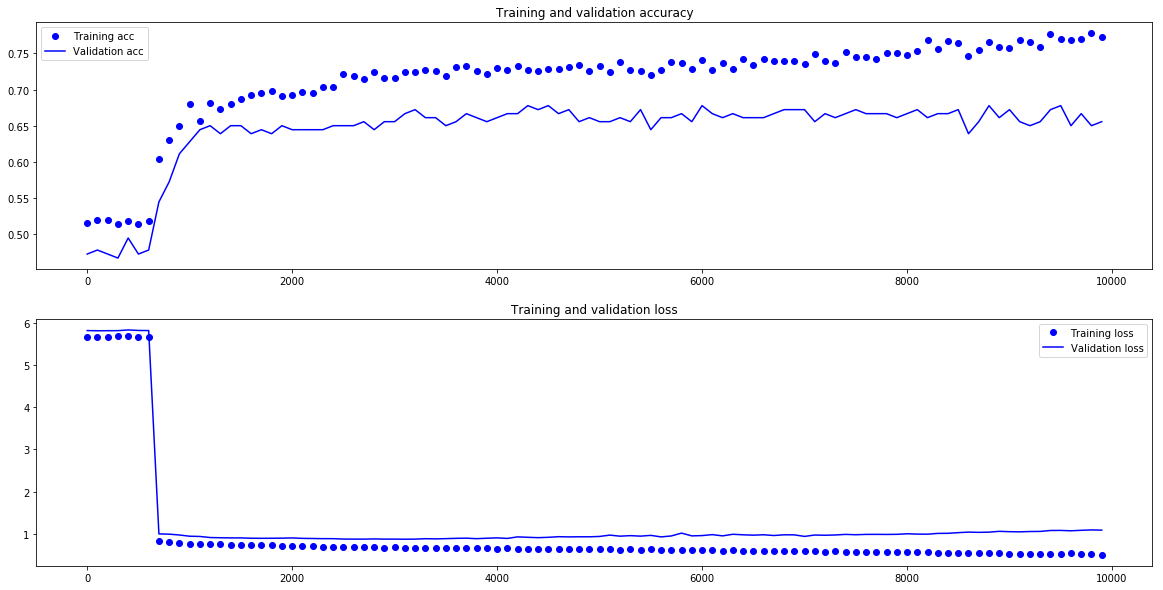

In [22]:
plot_history(history)

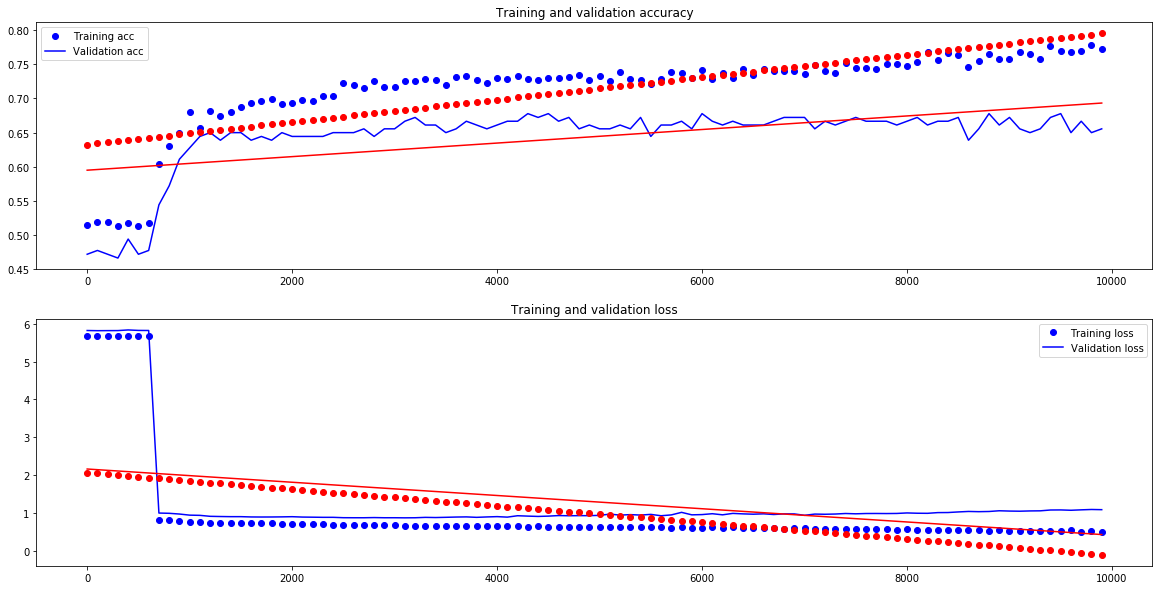

In [24]:
# sometimes it is not so easy if we still have a change, plot a line through the data
plot_history(history, plot_line=True)

In [ ]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data")

In [ ]:
plot_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data")

## We you have a decent model, save it for the next steps

In [ ]:
model.save('insurance.hdf5')

In [ ]:
!ls -l insurance.hdf5